In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.random as random
import jax.numpy as jnp
from jax import jit, grad, vmap
from jax.example_libraries import optimizers

import neural_tangents as nt
from neural_tangents import stax

from kernel_generalization import kernel_simulation as ker_sim
from kernel_generalization import kernel_spectrum as ker_spec
from kernel_generalization.utils import gegenbauer

from matplotlib.cm import get_cmap
plt.rcParams.update({'font.size': 14})
name = "tab20"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors 
savedir = "/n/holyscratch01/pehlevan_lab/Lab/aatanasov/"
figdir = "figures/"


In [3]:
print(jax.devices())

[GpuDevice(id=0, process_index=0), GpuDevice(id=1, process_index=0)]


In [4]:
def generate_synth_data(p, dim, key):
  x0 = random.normal(key, shape=(p,dim))
  x = x0 / np.outer(np.linalg.norm(x0, axis=1), np.ones(dim))
  return jnp.array(x)

def pure_target_fn(X, beta, k):
  dim = len(beta)
  z = np.dot(X, beta)
  y = gegenbauer.gegenbauer(z, k+1, dim)[k,:]
  return jnp.array(y)[:, jnp.newaxis]

def generate_train_data(p, beta, k, key):
  emp_dim = 100
  dim = len(beta)
  key, emp_key = random.split(key)
  X = generate_synth_data(p, dim, key)
  y = pure_target_fn(X, beta, k)
  return X, y

def format_ps(pvals):
  result = np.zeros(len(pvals), dtype=int)
  for i, p in enumerate(pvals):
    if p < 10:
      result[i] = p + (p % 2)
    elif p < 300:
      result[i] = p + 10 - (p % 10)
    elif p < 3000:
      result[i] = p + 100 - (p % 100)
    else:
      result[i] = p + 1000 - p % 1000
  return result     

from functools import partial
from jax import jvp, grad, jit
# from jax.tree_util import tree_multimap
# from jax import jvp, grad, jit


# @partial(partial, tree_multimap)
# def norm(x, y):
#   return np.sum((x - y) ** 2)  # actually a _squared_ norm ;)

def param_dist(params0, paramsf):
  diff = norm(list(params0), list(paramsf))  
  return jnp.sum(jnp.array(jax.tree_util.tree_leaves(diff)))

def param_diff(params0, paramsf):
  return jax.tree_map(lambda x, y: y-x, params0, paramsf)

def jacobian_vector(apply_fn, X, params0, deltaparams):
  f0 = lambda params: apply_fn(params, X)
  return jvp(f0, [params0], [deltaparams])[1]

def hessian_vector(apply_fn, X, params0, deltaparams):
  f0 = lambda params: apply_fn(params, X)
  df0 = lambda params: jvp(f0, [params], [deltaparams])[1]
  return jvp(df0, [params0], [deltaparams])[1]

import neural_tangents as nt
from neural_tangents import stax

# Generate fully connected NN architecture
def fully_connected(num_layers, width, sigma):
  layers = []
  for i in range(num_layers):
    layers += [stax.Dense(width, W_std = sigma, b_std = 0), stax.Relu()]
  layers += [stax.Dense(1, W_std=sigma, b_std=0)] 
  return stax.serial(*layers)

def make_jax(params):
  new_params = []
  for i, layer in enumerate(params):
    new_layer = []
    for wnbs in layer:
      new_wnbs = jnp.array(wnbs)
      new_layer += [new_wnbs]
    new_layer = tuple(new_layer)
    new_params += [new_layer]
  return new_params

In [5]:
num_repeats = 20
num_repeats_ker = num_repeats #150
num_repeats_nn = num_repeats #5
num_iter_nn = int(3e4)
min_loss_nn = 1e-6

## NN Hyperparameters
lr = 0.008   # Only being used with adam
layers = 2   # Hidden layers
depth = layers + 1

# For now we are actually not ensembling
ensemble_size_list = [3]

## Dimension, sample sizes, max eigenvalue mode to generate data
dim = 10
num_p = 15
num_n = 5
logpmin = .5
lognmin = 1.5
logpmax = np.log10(10000-1)
lognmax = np.log10(1000)
p_test = 2000
kmax = 200

num_repeats_eNTK = num_repeats_ker
ensemble_size = 1

# This is the sweep that we are going to be doing:
pvals = np.logspace(logpmin, logpmax, num=num_p).astype('int')
nvals = np.logspace(lognmin, lognmax, num=num_n).astype('int')
pvals = format_ps(pvals)

In [9]:
k = 2

# Random keys
key = random.PRNGKey(0)
data_key, init_key = random.split(key)
init_keys = random.split(init_key, max(num_repeats_nn, num_repeats_ker))
beta_key, train_key, test_key = random.split(data_key, 3)
train_key = random.split(train_key, len(pvals))
beta_key, const_key = random.split(beta_key)

test_key = random.PRNGKey(0)
beta_key, const_key, test_key = random.split(test_key, 3)

# Data:
ks = [1,2,3,4]
ys_test = []
for k in ks:
  beta = generate_synth_data(1, dim, beta_key)[0,:]
  y_const = np.sqrt(np.mean((generate_train_data(1000, beta, k, const_key)[1])**2))
  Xs_train = []; ys_train = []
  for i, p in enumerate(pvals):
    X_train, y_train = generate_train_data(p, beta, k, train_key[i])
    y_train = y_train/y_const
    Xs_train += [X_train]
    ys_train += [y_train]
  X_test, y_test = generate_train_data(p_test, beta, k, test_key)
  y_test = y_test/y_const
  ys_test +=[y_test]
  test_set = X_test, y_test

sigmas = [0.1, 0.5, 1.0, 10.0, 20]
widths = nvals[1:6]
numN = len(widths)
numS = len(sigmas)
numK = 4
numE = 20
numD = 20
numP = 15
P_test = 2000
NTK_errs = np.zeros(shape=(numK, numS, numP, numD)) 
eNTK0_errs = np.zeros(shape=(numK, numS, numN, numP, numE, numD)) 
yhats_eNTK0 = np.zeros(shape=(numK, numS, numN, numP, numE, numD, P_test, 1)) 
eNTKf_errs = np.zeros(shape=(numK, numS, numN, numP, numE, numD)) 
yhats_eNTKf = np.zeros(shape=(numK, numS, numN, numP, numE, numD, P_test, 1)) 
NN_errs = np.zeros(shape=(numK, numS, numN, numP, numE, numD))
yhats_NN = np.zeros(shape=(numK, numS, numN, numP, numE, numD, P_test, 1)) 
eNTK0_err_rat = np.zeros(shape=(numK, numS, numN, numP, numE, numD))
NN_err_rat = np.zeros(shape=(numK, numS, numN, numP, numE, numD))

  
for idk, k in enumerate(ks):
  print(f"Doing k = {k}")
  y_test = ys_test[idk]
  for d in range(numD):
    print(f"d = {d}")
    for i, sigma in enumerate(sigmas):
      try: NTK_errs[idk, i, :, d] = np.load(savedir+"inf_err_L={}_k={}_s={:.2f}_d={}.npy".format(depth, k, sigma, d))
      except: print(f"NTK error at sigma={sigma} d={d}")
      for j, width in enumerate(widths):    
        try: 
          NN_errs[idk, i, j, :, :, d] = np.load(savedir+"gen_err_NN_N={}_L={}_k={}_s={:.2f}_d={}.npy".format(width, depth, k, sigma, d))
          yhats_NN[idk, i, j, :, :, d, :, :] = np.load(savedir+"yhats_NN_N={}_L={}_k={}_s={:.2f}_d={}.npy".format(width, depth, k, sigma, d))      
        except FileNotFoundError as e: print(f"NN error at width={width}, sigma={sigma} d={d}")
        try: 
          eNTK0_errs[idk, i, j, :, :, d] = np.load(savedir+"gen_err_eNTK0_N={}_L={}_k={}_s={:.2f}_d={}.npy".format(width, depth, k, sigma, d))
          yhats_eNTK0[idk, i, j, :, :, d, :, :] = np.load(savedir+"yhats_eNTK0_N={}_L={}_k={}_s={:.2f}_d={}.npy".format(width, depth, k, sigma, d))
        except FileNotFoundError as e: print(f"eNTK0 error at width={width}, sigma={sigma} d={d}")
        try: 
          eNTKf_errs[idk, i, j, :, :, d] = np.load(savedir+"gen_err_eNTKf_N={}_L={}_k={}_s={:.2f}_d={}.npy".format(width, depth, k, sigma, d))
          yhats_eNTKf[idk, i, j, :, :, d, :, :] = np.load(savedir+"yhats_eNTKf_N={}_L={}_k={}_s={:.2f}_d={}.npy".format(width, depth, k, sigma, d))
        except FileNotFoundError as e: print(f"eNTKf error at width={width}, sigma={sigma} d={d}")

        

    
    

Doing k = 1
d = 0
d = 1
d = 2
d = 3
d = 4
eNTK0 error at width=1000, sigma=0.5 d=4
eNTKf error at width=1000, sigma=0.5 d=4
eNTK0 error at width=1000, sigma=10.0 d=4
eNTKf error at width=1000, sigma=10.0 d=4
d = 5
eNTK0 error at width=1000, sigma=0.5 d=5
eNTKf error at width=1000, sigma=0.5 d=5
eNTK0 error at width=1000, sigma=1.0 d=5
eNTKf error at width=1000, sigma=1.0 d=5
eNTK0 error at width=1000, sigma=10.0 d=5
eNTKf error at width=1000, sigma=10.0 d=5
d = 6
d = 7
eNTK0 error at width=1000, sigma=10.0 d=7
eNTKf error at width=1000, sigma=10.0 d=7
d = 8
eNTK0 error at width=1000, sigma=0.5 d=8
eNTKf error at width=1000, sigma=0.5 d=8
d = 9
d = 10
d = 11
d = 12
NN error at width=74, sigma=10.0 d=12
eNTK0 error at width=74, sigma=10.0 d=12
eNTKf error at width=74, sigma=10.0 d=12
NN error at width=177, sigma=10.0 d=12
eNTK0 error at width=177, sigma=10.0 d=12
eNTKf error at width=177, sigma=10.0 d=12
NN error at width=421, sigma=10.0 d=12
eNTK0 error at width=421, sigma=10.0 d=12
eNT

In [11]:
def zero_to_nan(d):
    array = np.array(d)
    array[array == 0] = np.NaN
    return array

NTK_errs = zero_to_nan(NTK_errs)
eNTK0_errs = zero_to_nan(eNTK0_errs)
eNTKf_errs = zero_to_nan(eNTK0_errs)
NN_errs = zero_to_nan(NN_errs);
yhats_eNTK0 = zero_to_nan(yhats_eNTK0)
yhats_NN = zero_to_nan(yhats_NN);

In [12]:
ys_test = np.array(ys_test)

In [13]:
# y_hats_NN: k, s, n p e d P_test, 1
ys_test_new = np.transpose(np.broadcast_to(ys_test, (numS, numN, numP, numD, *ys_test.shape)), (4, 0, 1, 2, 3, 5, 6))
NN_errs_ens = np.nanmean((np.nanmean(yhats_NN, axis=-4) - ys_test_new)**2, axis=(-1, -2, -3))
NN_errs_avg = np.nanmean(NN_errs, axis=(-1, -2))
eNTK0_errs_ens = np.nanmean((np.nanmean(yhats_eNTK0, axis=-4) - ys_test_new)**2, axis=(-1, -2, -3))
eNTK0_errs_avg = np.nanmean(eNTK0_errs, axis=(-1, -2))

<ipython-input-13-b483d567b221>:3: RuntimeWarning: Mean of empty slice
  NN_errs_ens = np.nanmean((np.nanmean(yhats_NN, axis=-4) - ys_test_new)**2, axis=(-1, -2, -3))
<ipython-input-13-b483d567b221>:5: RuntimeWarning: Mean of empty slice
  eNTK0_errs_ens = np.nanmean((np.nanmean(yhats_eNTK0, axis=-4) - ys_test_new)**2, axis=(-1, -2, -3))
<ipython-input-13-b483d567b221>:6: RuntimeWarning: Mean of empty slice
  eNTK0_errs_avg = np.nanmean(eNTK0_errs, axis=(-1, -2))


In [37]:
yhats_NN.shape

(4, 5, 4, 15, 20, 20, 2000, 1)

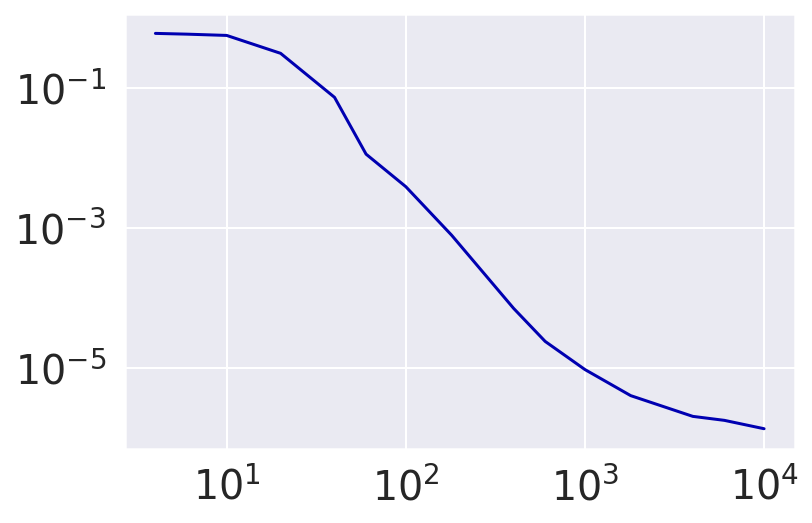

In [47]:
plt.loglog(pvals, [np.nanmean((np.nanmean(yhats_NN[0, -5, -1, pidx, :, 0, :, 0], axis=-2) - ys_test[0, :, 0])**2) for pidx in range(len(pvals))])

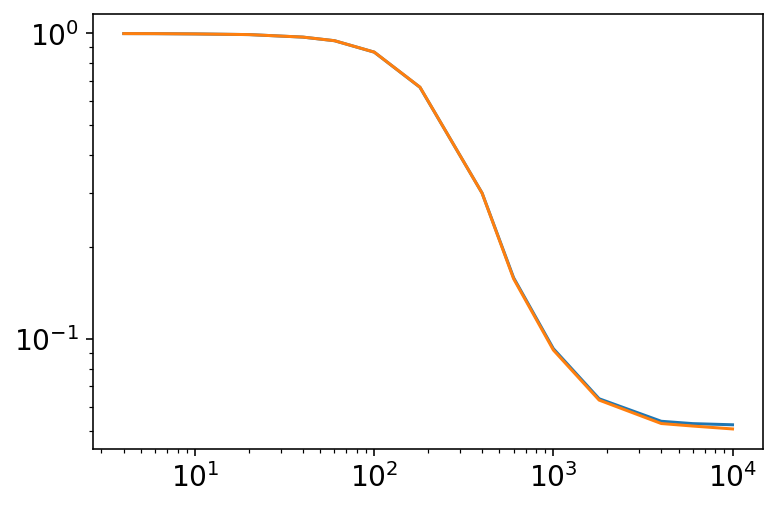

In [14]:
NN_err_rat = NN_errs_ens/NN_errs_avg
eNTK0_err_rat = eNTK0_errs_ens/eNTK0_errs_avg
plt.loglog(pvals, NN_err_rat[0, -1, -1, :])
plt.loglog(pvals, eNTK0_err_rat[0, -1, -1, :])

In [15]:
import seaborn as sns
sns.set(font_scale=1.8)
sns.set_style("darkgrid")
sns.set_palette("seismic")
sns

<module 'seaborn' from '/n/home00/aatanasov/.conda/envs/ffcv/lib/python3.9/site-packages/seaborn/__init__.py'>

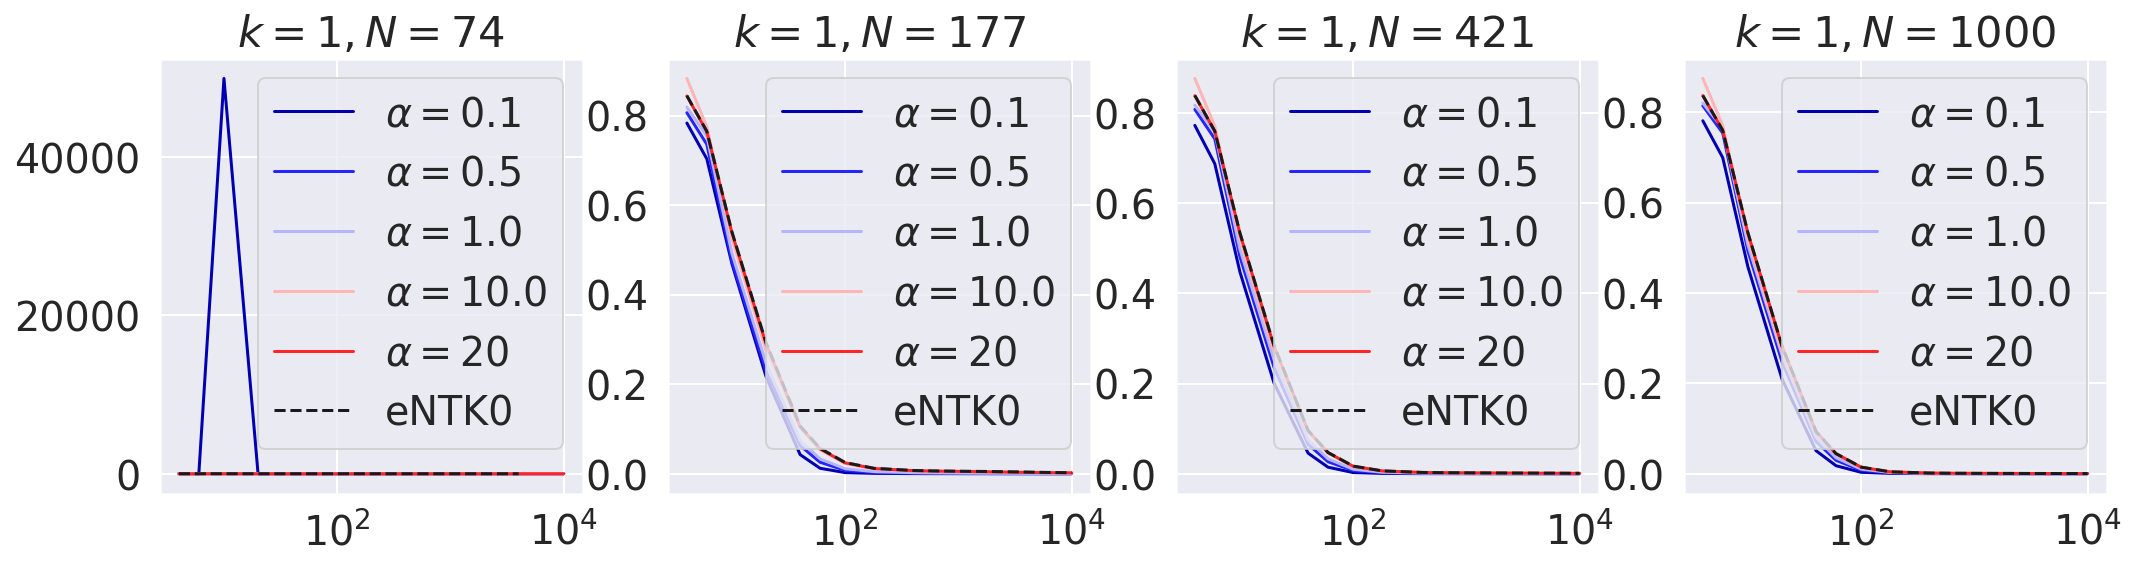

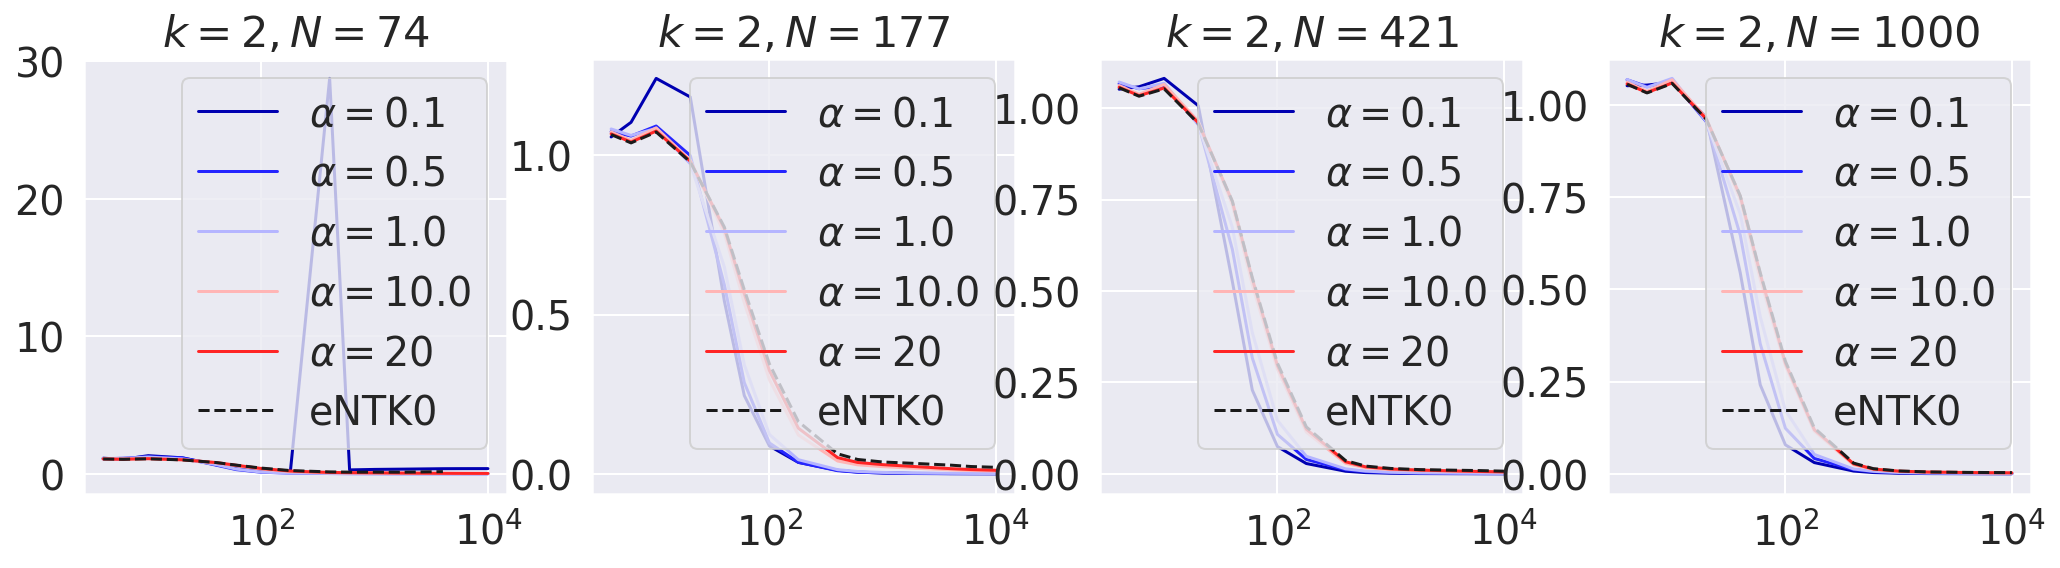

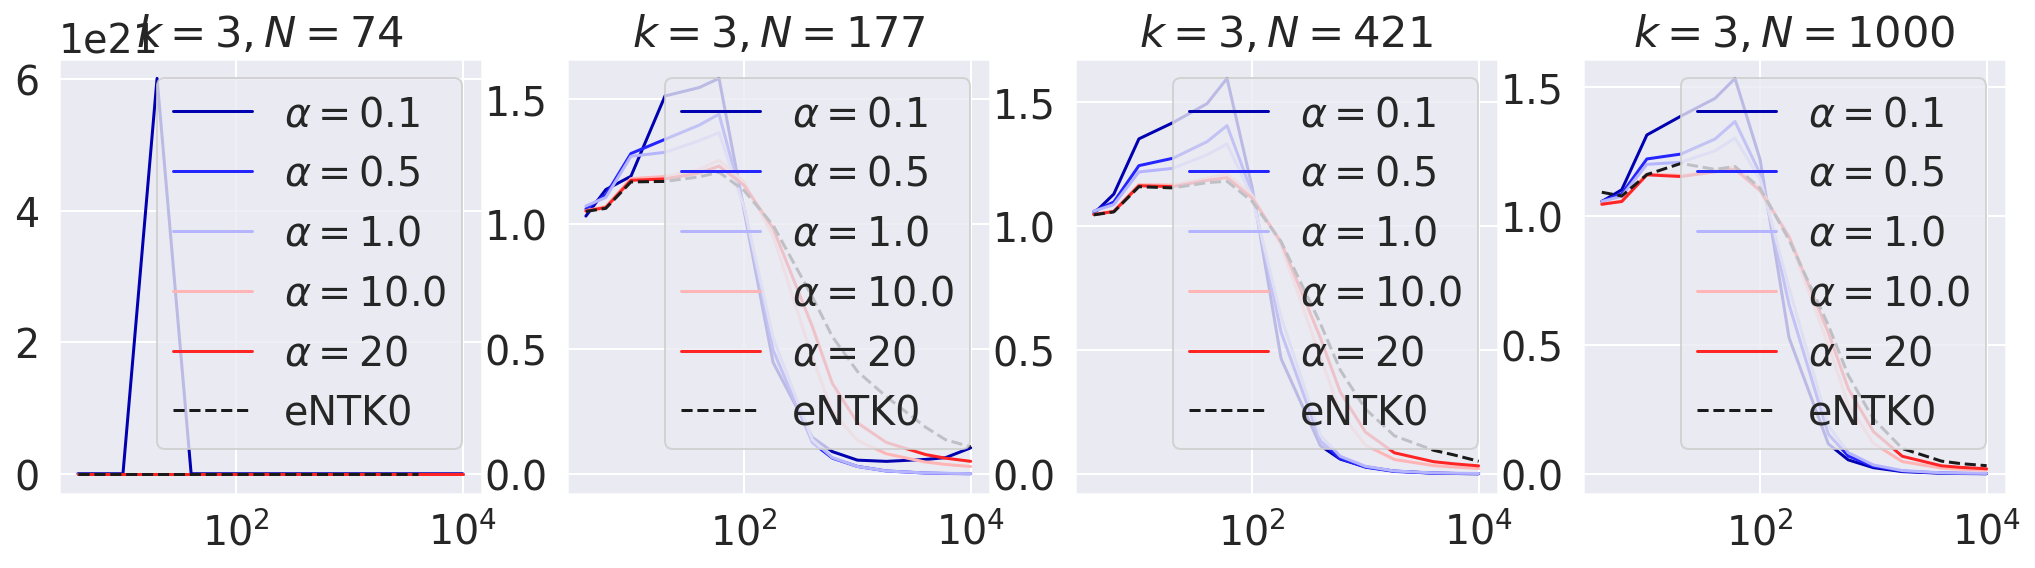

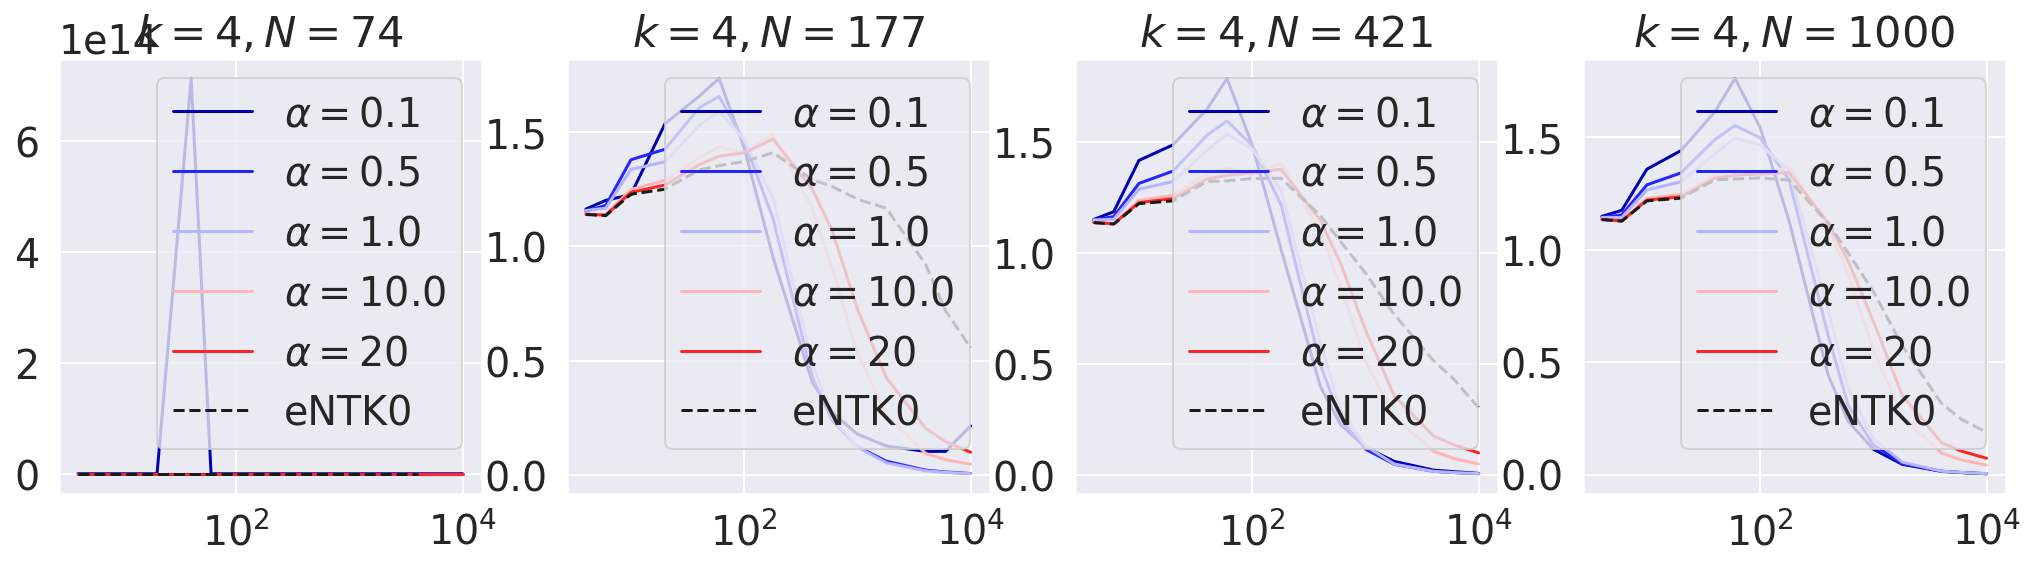

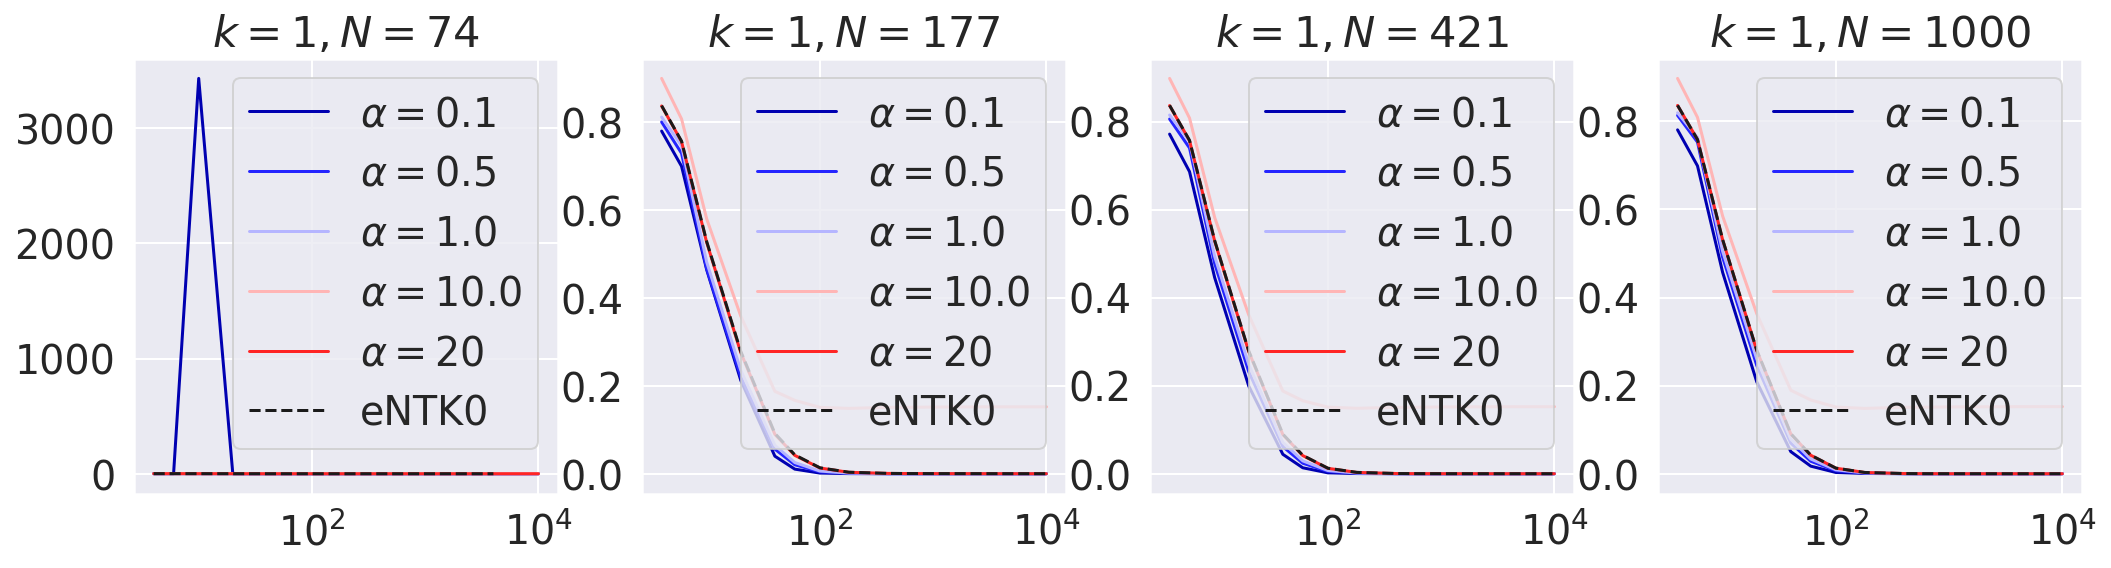

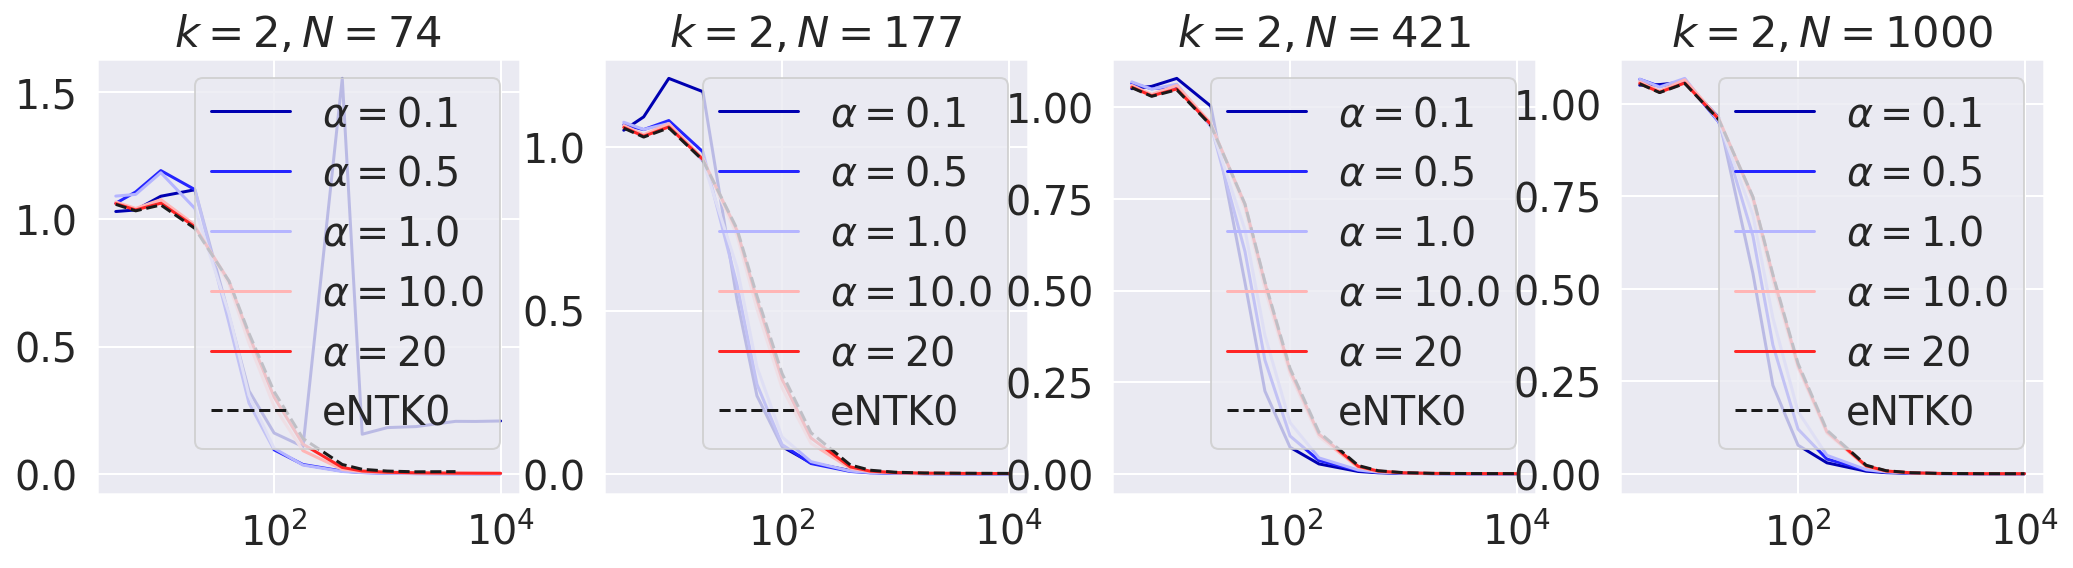

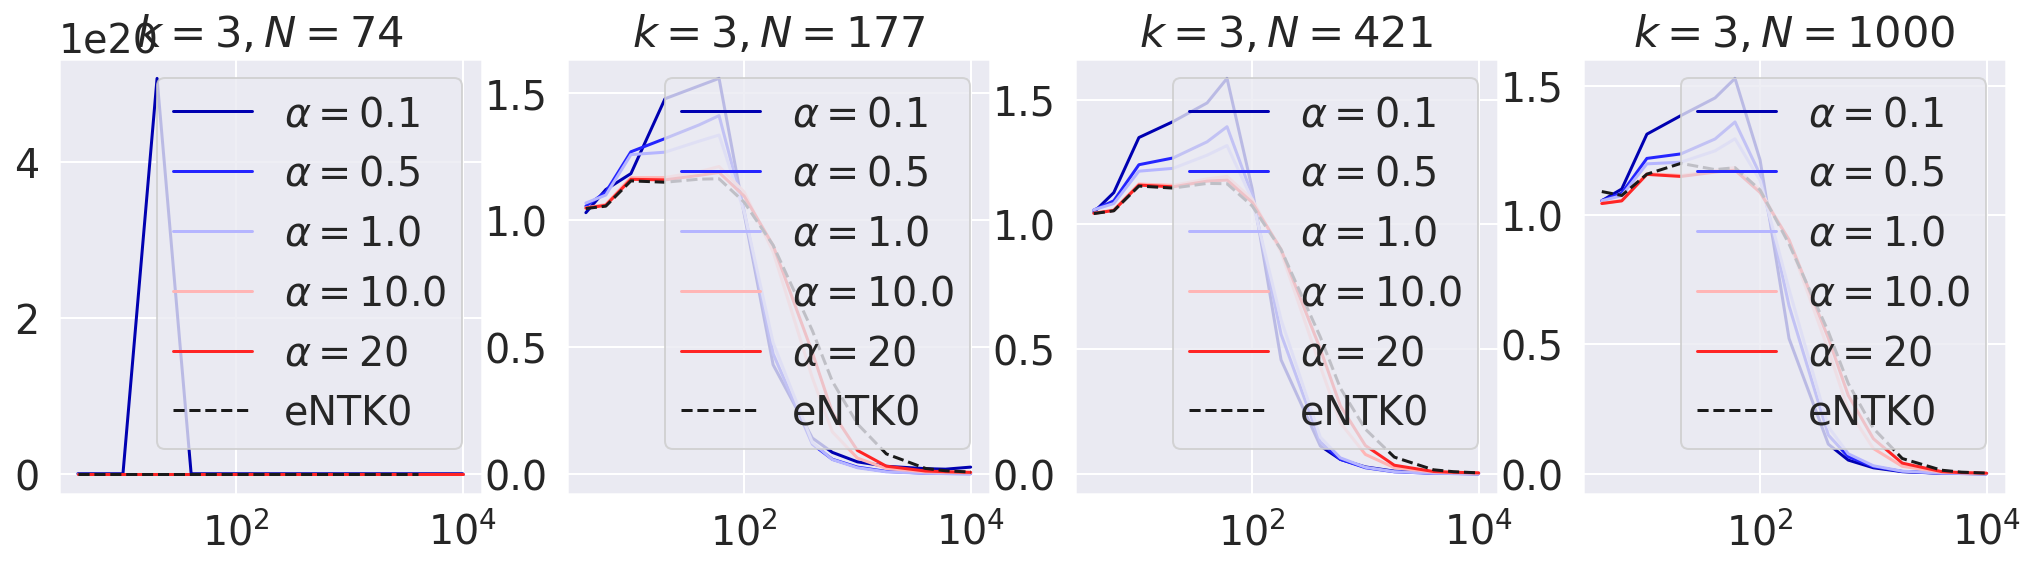

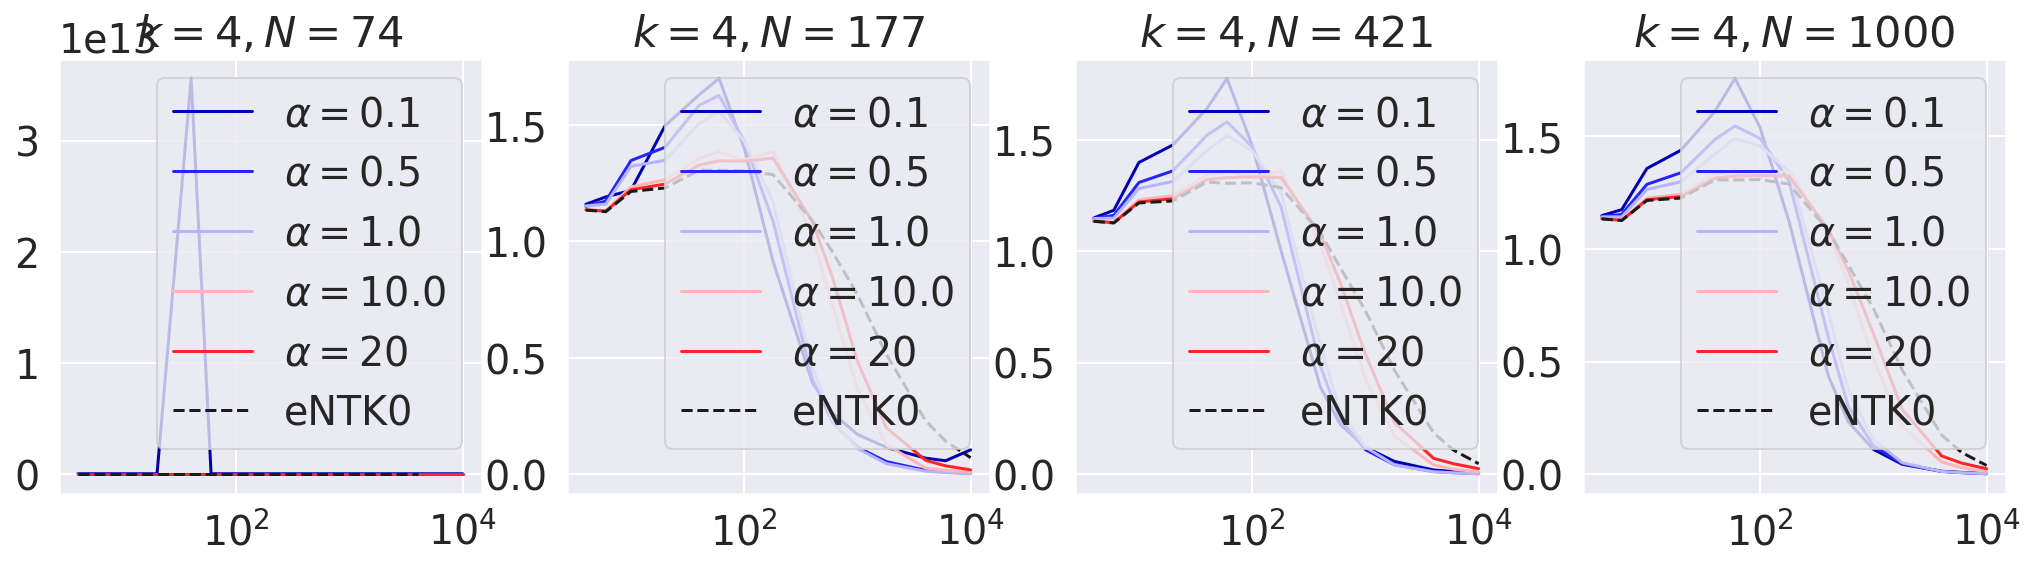

In [16]:
for idk, k in enumerate([1,2,3,4]):
    plt.figure(figsize=(22, 4))
    for j, width in enumerate(widths):
        plt.subplot(1, 5, 1+j)
        plt.title(f"$k = {k}, N={width}$")
        for i, sigma in enumerate(sigmas):
            plt.semilogx(pvals,  NN_errs_avg[idk, i, j, :], f'C{i}', label=f"$\\alpha={sigma}$")
        
        plt.semilogx(pvals, eNTK0_errs_avg[idk, i, j, :], f'k--', label="eNTK0")
        plt.legend()

for idk, k in enumerate([1,2,3,4]):
    plt.figure(figsize=(22, 4))
    for j, width in enumerate(widths):
        plt.subplot(1, 5, 1+j)
        plt.title(f"$k = {k}, N={width}$")
        for i, sigma in enumerate(sigmas):
            plt.semilogx(pvals,  NN_errs_ens[idk, i, j, :], f'C{i}', label=f"$\\alpha={sigma}$")
        
        plt.semilogx(pvals, eNTK0_errs_ens[idk, i, j, :], f'k--', label="eNTK0")
        plt.legend()

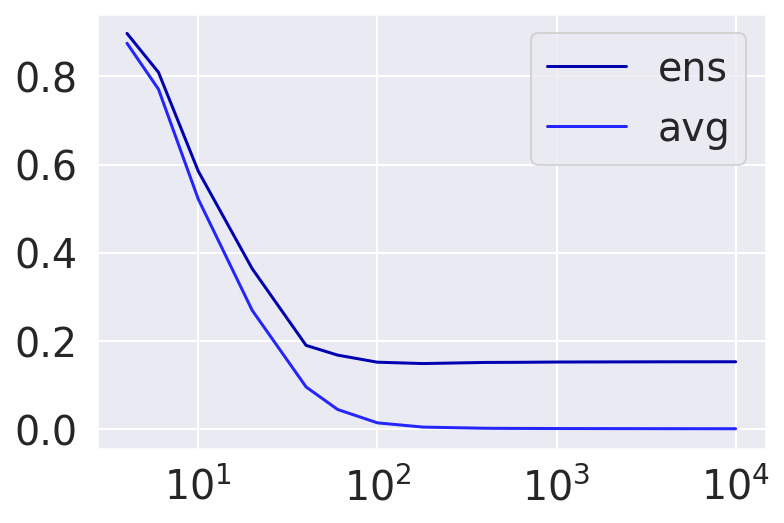

In [36]:
plt.semilogx(pvals, NN_errs_ens[0, 3, -1, :], label="ens")
plt.semilogx(pvals, NN_errs_avg[0, 3, -1, :], label="avg")
# plt.semilogx(pvals, NN_err_rat[0, 3, -1, :])
plt.legend()

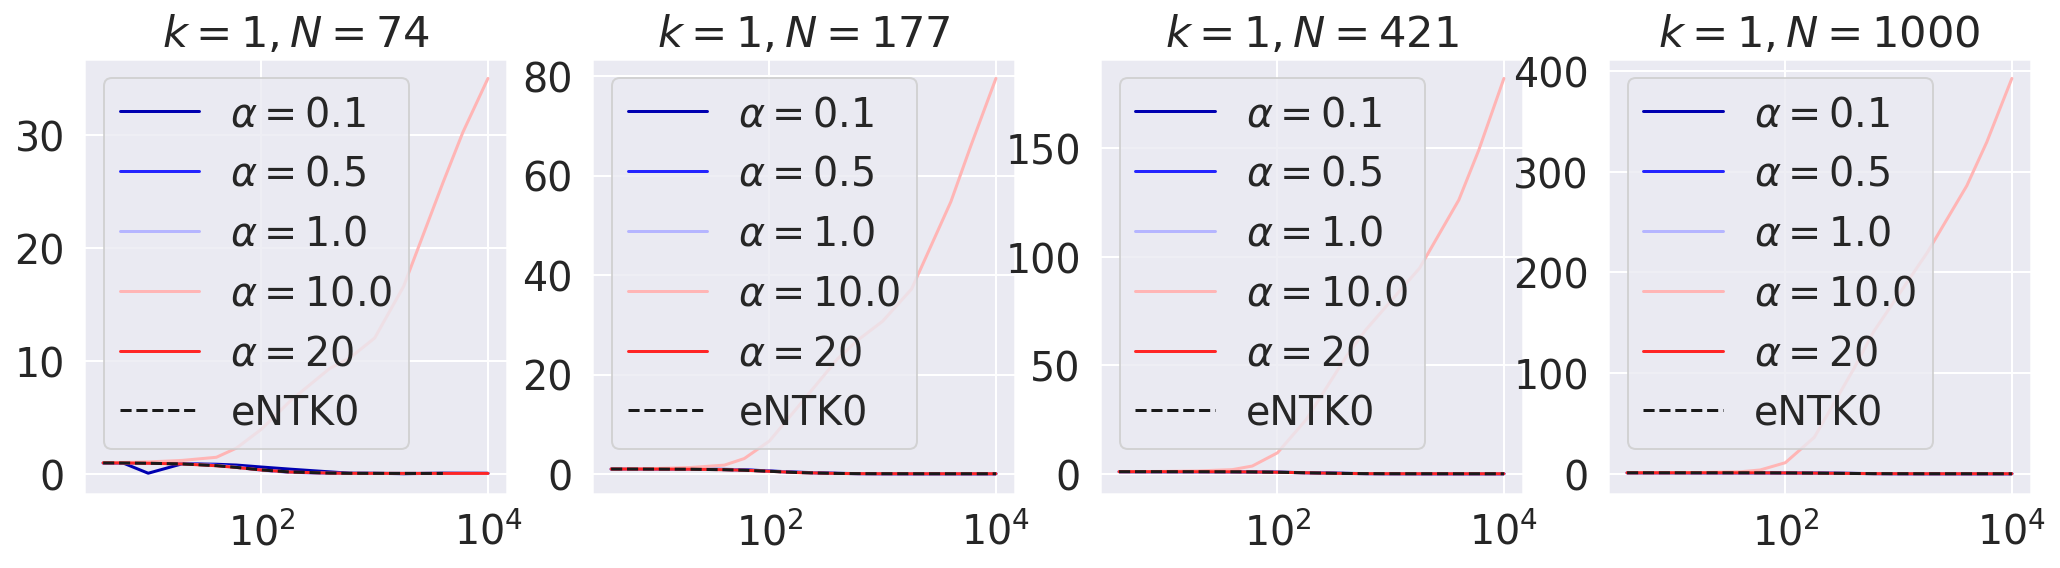

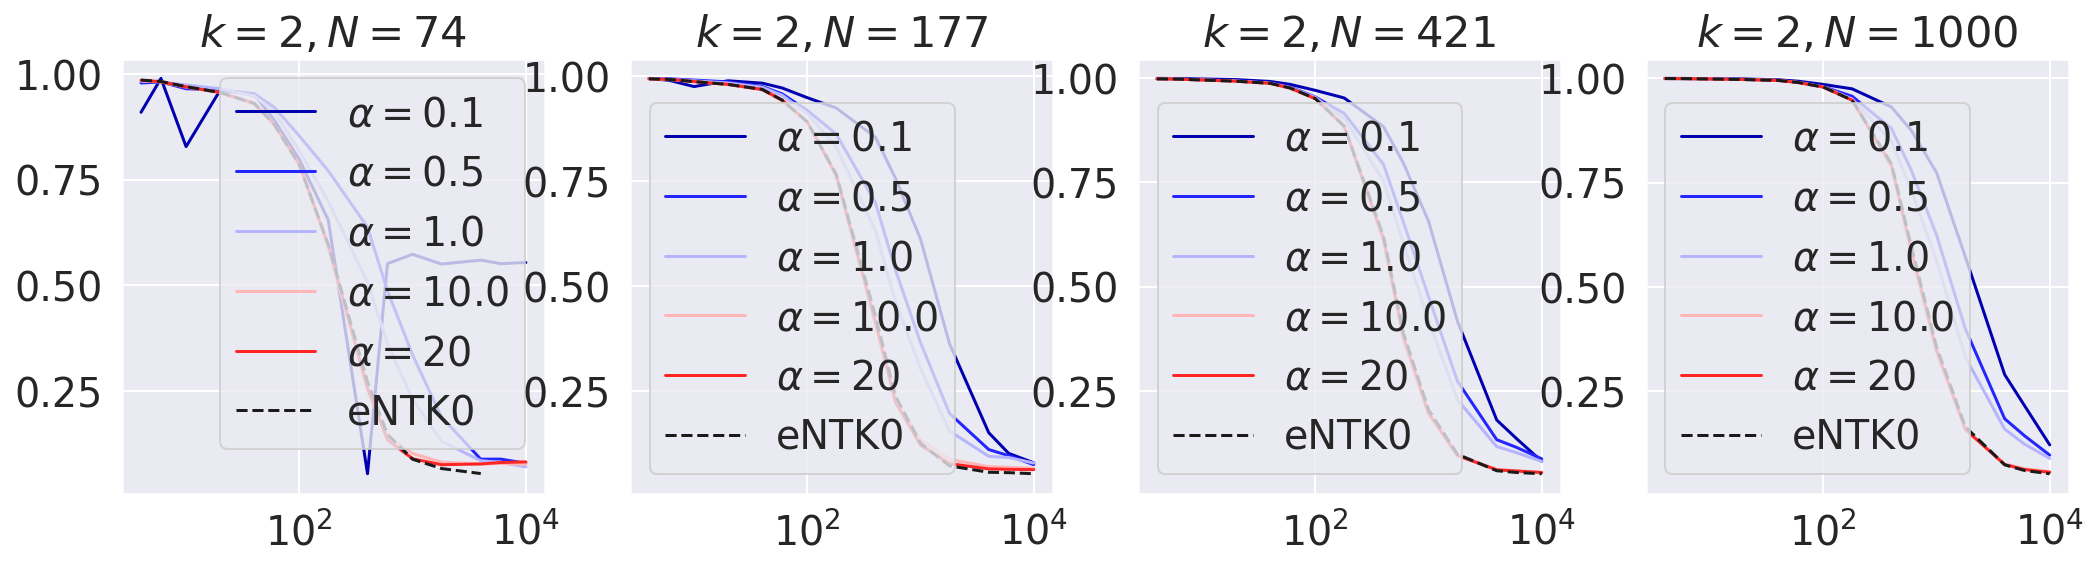

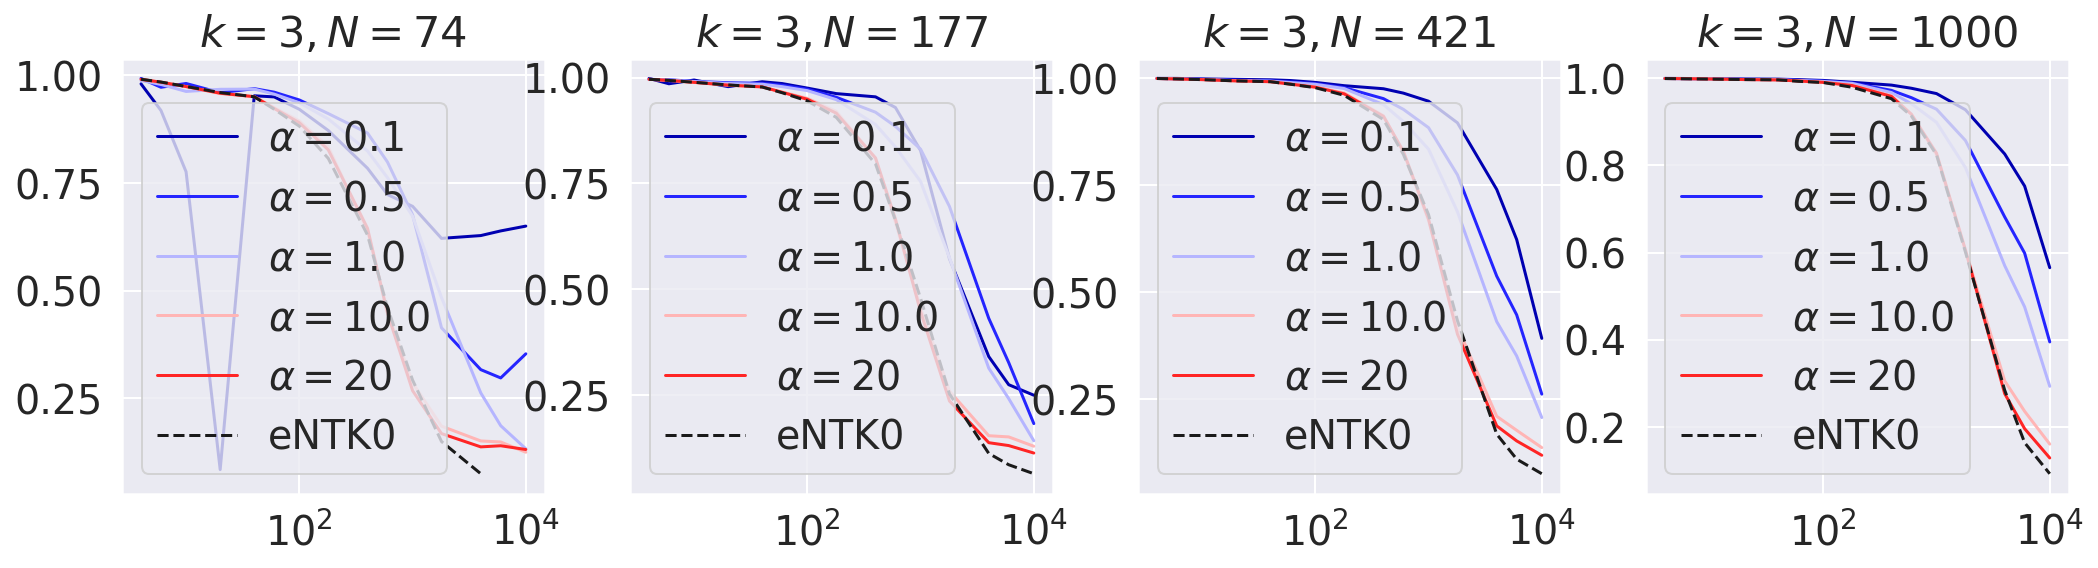

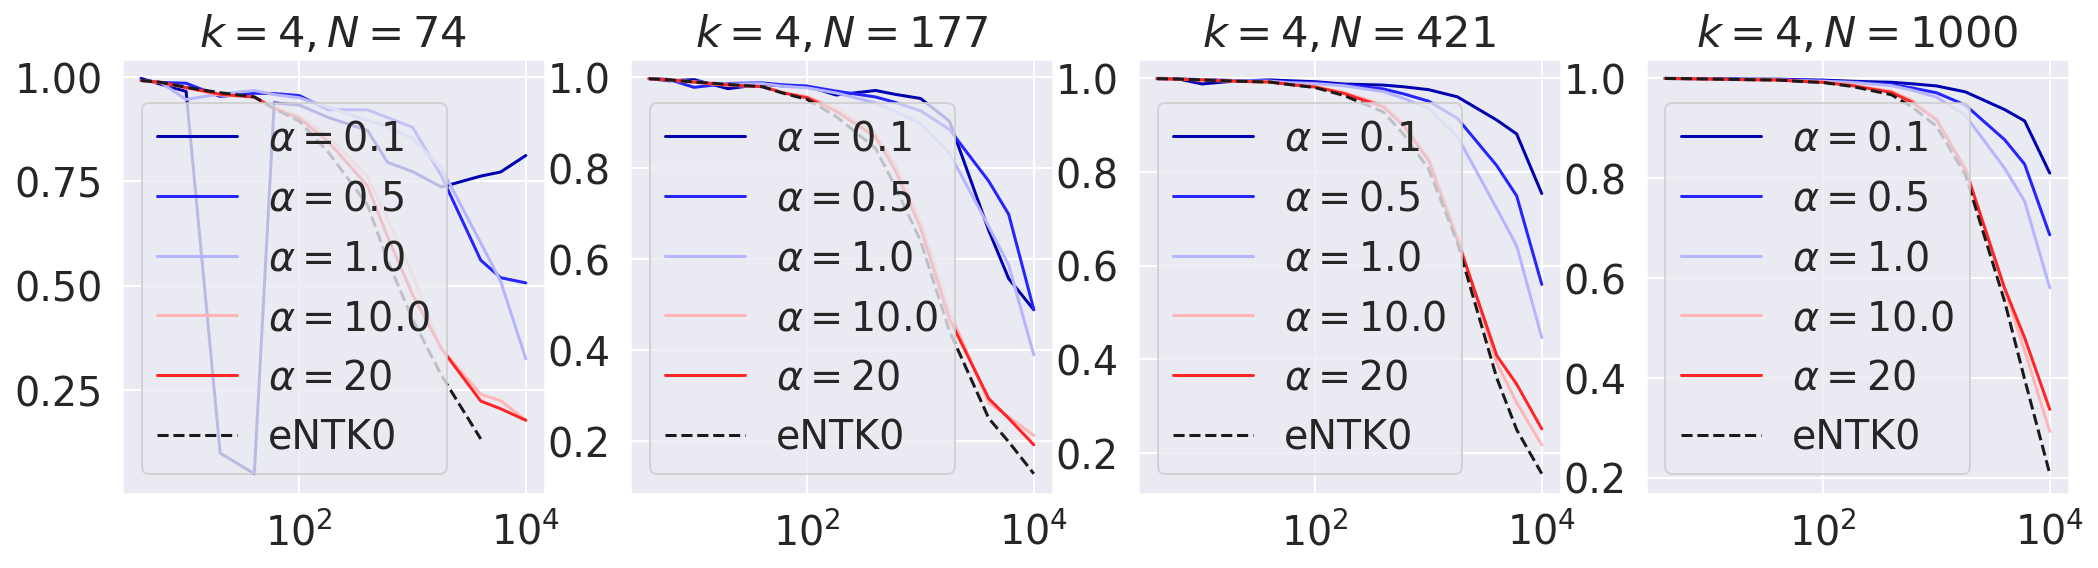

In [35]:
from scipy import interpolate
for idk, k in enumerate([1,2,3,4]):
    plt.figure(figsize=(22, 4))
    for j, width in enumerate(widths):
        plt.subplot(1, 5, 1+j)
        plt.title(f"$k = {k}, N={width}$")
        for i, sigma in enumerate(sigmas):
            plt.semilogx(pvals,  NN_err_rat[idk, i, j, :], f'C{i}', label=f"$\\alpha={sigma}$")
        
        plt.semilogx(pvals, eNTK0_err_rat[idk, i, j, :], f'k--', label="eNTK0")
        plt.legend()

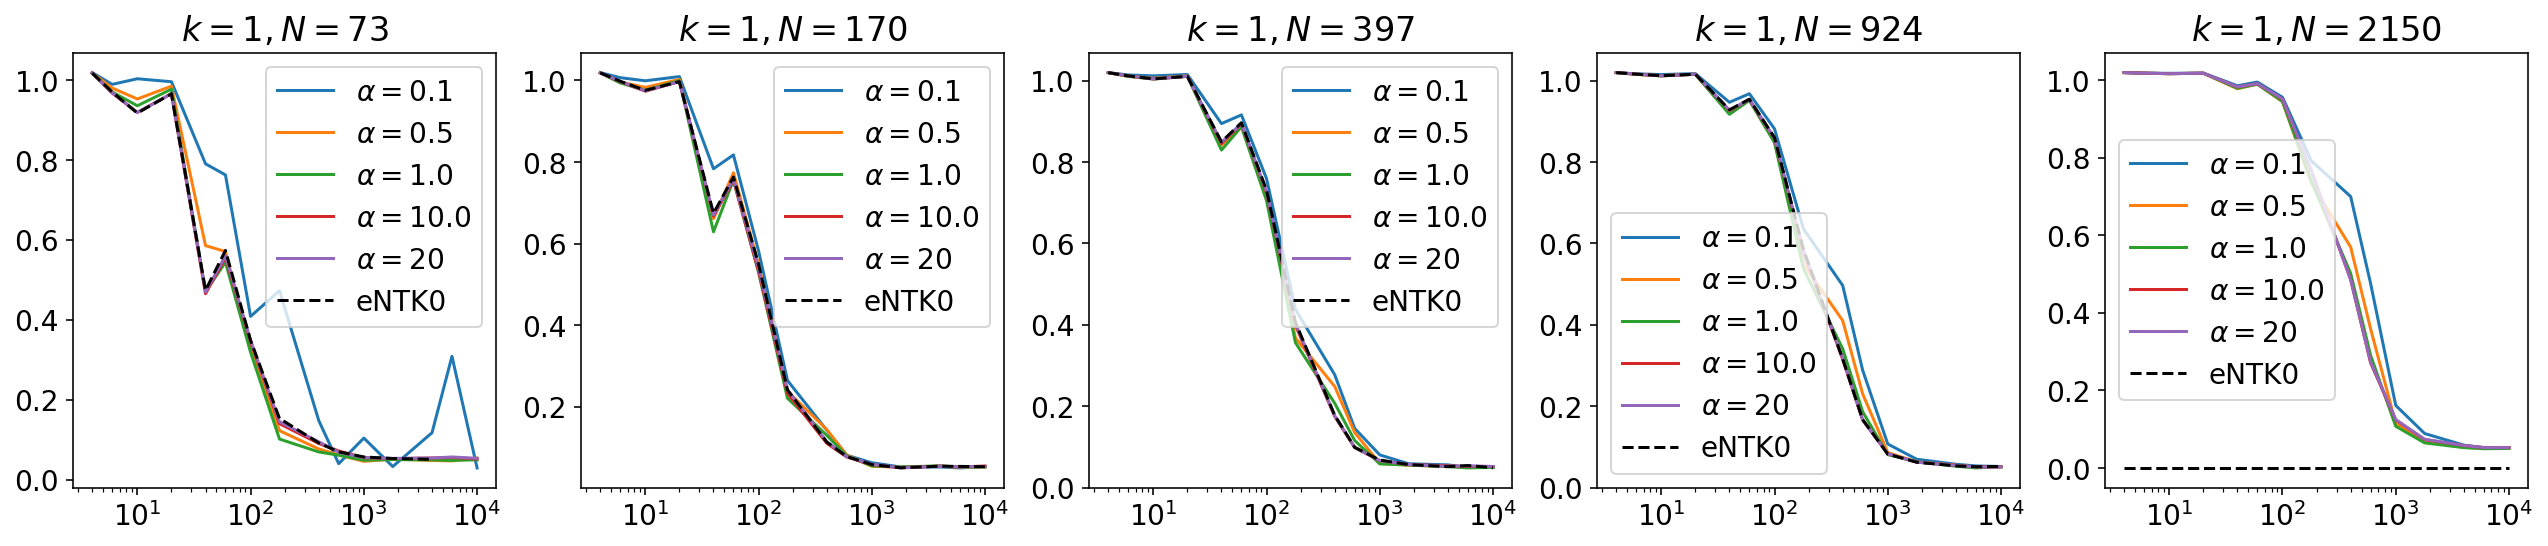

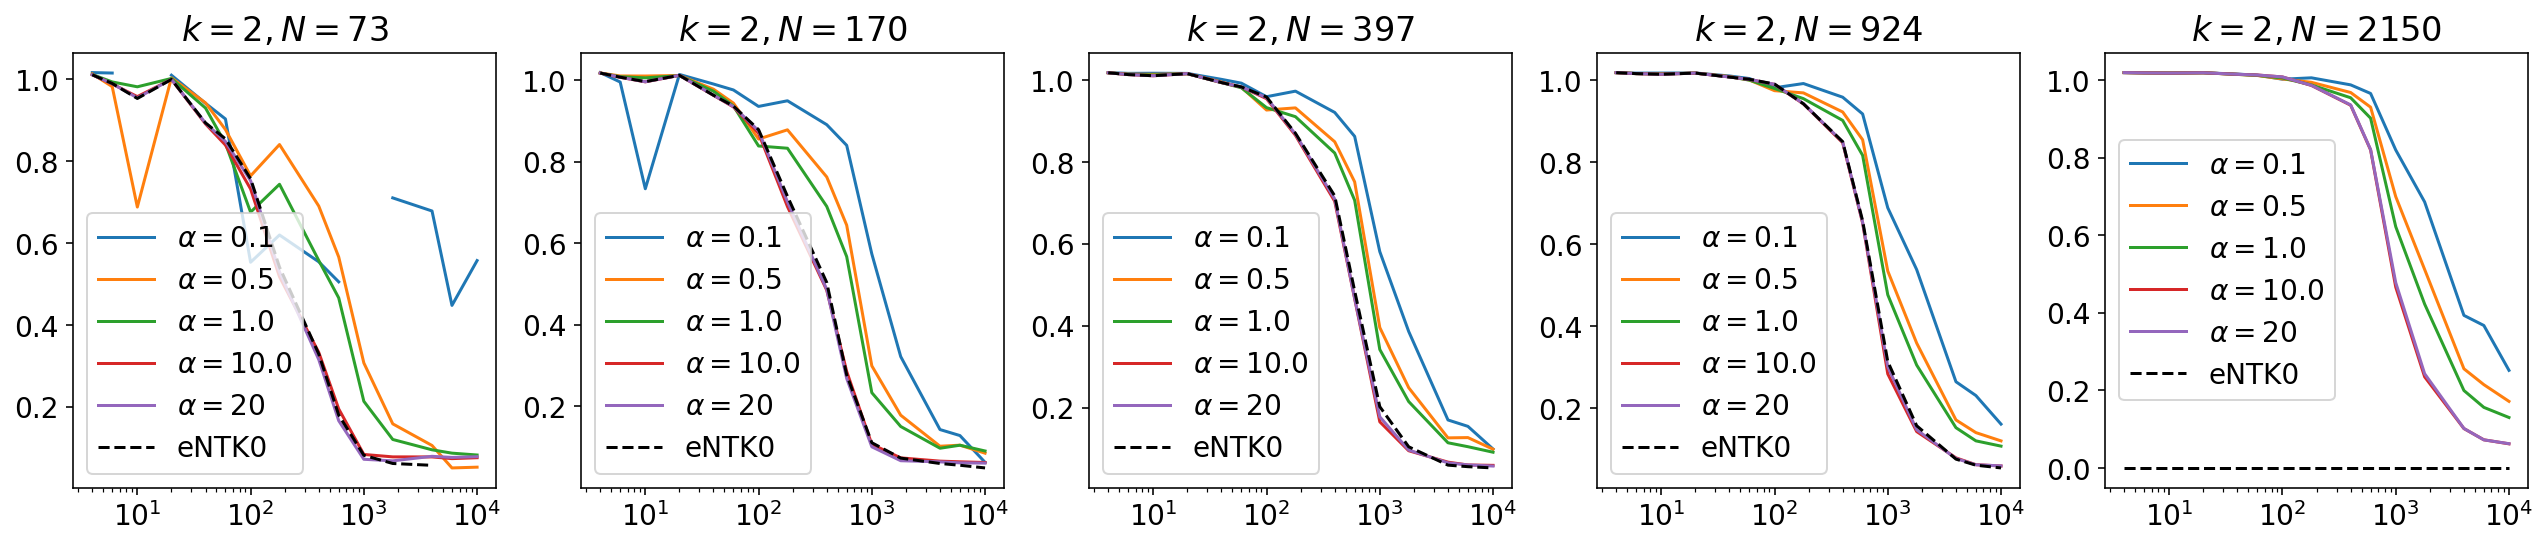

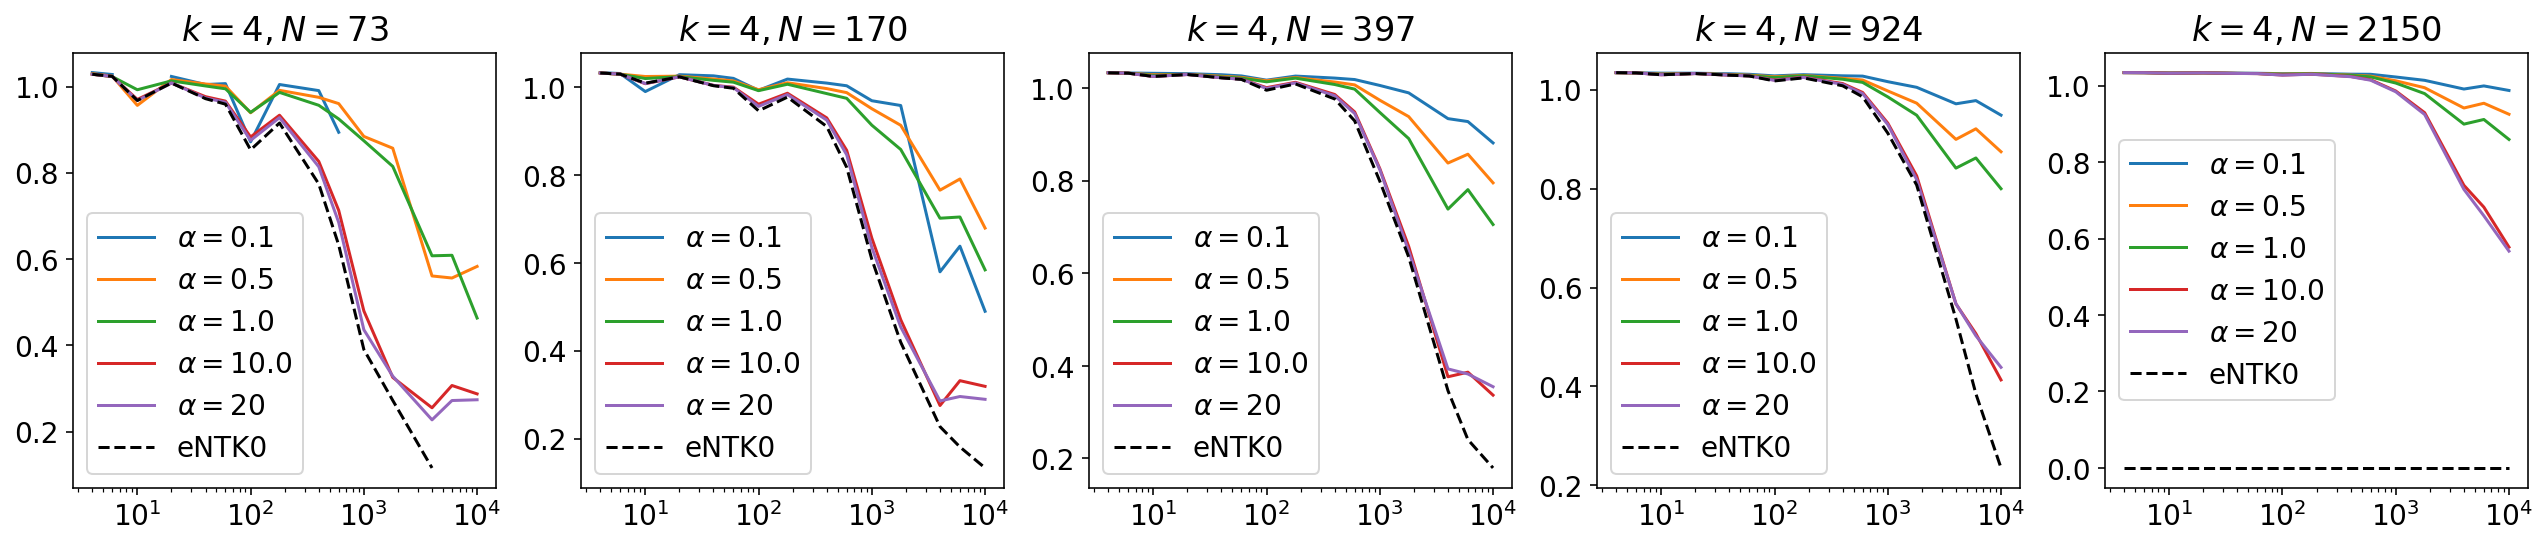

In [7]:
from scipy import interpolate
for idk, k in enumerate([1,2,4]):
    plt.figure(figsize=(22, 4))
    for j, width in enumerate(widths):
        plt.subplot(1, 5, 1+j)
        plt.title(f"$k = {k}, N={width}$")
        for i, sigma in enumerate(sigmas):
            plt.semilogx(pvals,  NN_err_rat[idk, i, j, :], f'C{i}', label=f"$\\alpha={sigma}$")
        
        plt.semilogx(pvals, eNTK0_err_rat[idk, i, j, :], f'k--', label="eNTK0")
        plt.legend()

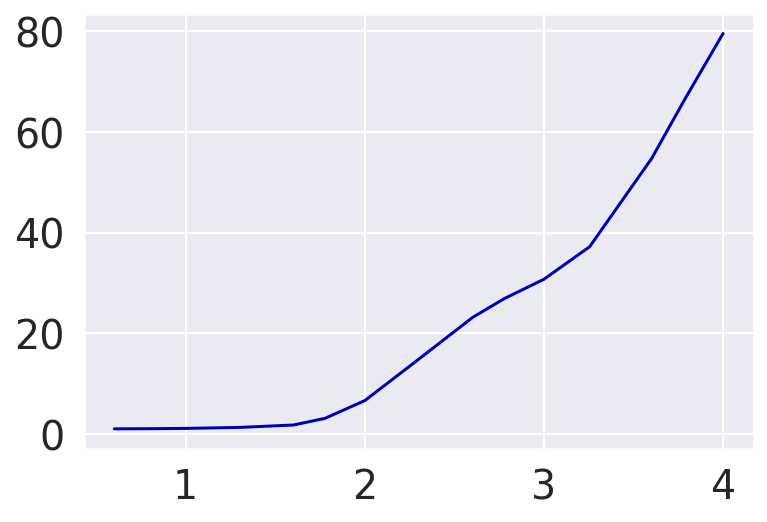

In [102]:
plt.plot(x, y)

In [61]:
from scipy import optimize
halves = np.zeros(shape=(numK, numS, numN))
halveseNTK = np.zeros(shape=(numK, numN))
for idk, k in enumerate([1, 2]):
    print(idk, k)
    for j, width in enumerate(widths):
        for i, sigma in enumerate(sigmas):
            if idk == 0 and i == 3: continue
            if j==0 and i == 0: continue
            print(f"k={k} N={width}, alpha={sigma}",end="\r")
            x = np.log10(pvals)
            y = NN_err_rat[idk, i, j, :]
            f = interpolate.interp1d(x, y, kind="linear")
            ans = optimize.root_scalar(lambda x: f(x)-0.5, method="bisect", bracket=[1,4]).root
            halves[idk, i, j] = ans

for idk, k in enumerate([1, 2]):
    for j, width in enumerate(widths[:]):
        x = np.log10(pvals)
        y = eNTK0_err_rat[idk, -1, j, :]
        f = interpolate.interp1d(x, y, kind="linear")
        ans = optimize.root_scalar(lambda x: f(x)-0.5, method="bisect", bracket=[1,4]).root
        halveseNTK[idk, j] = ans


0 1
1 2 N=1000, alpha=200


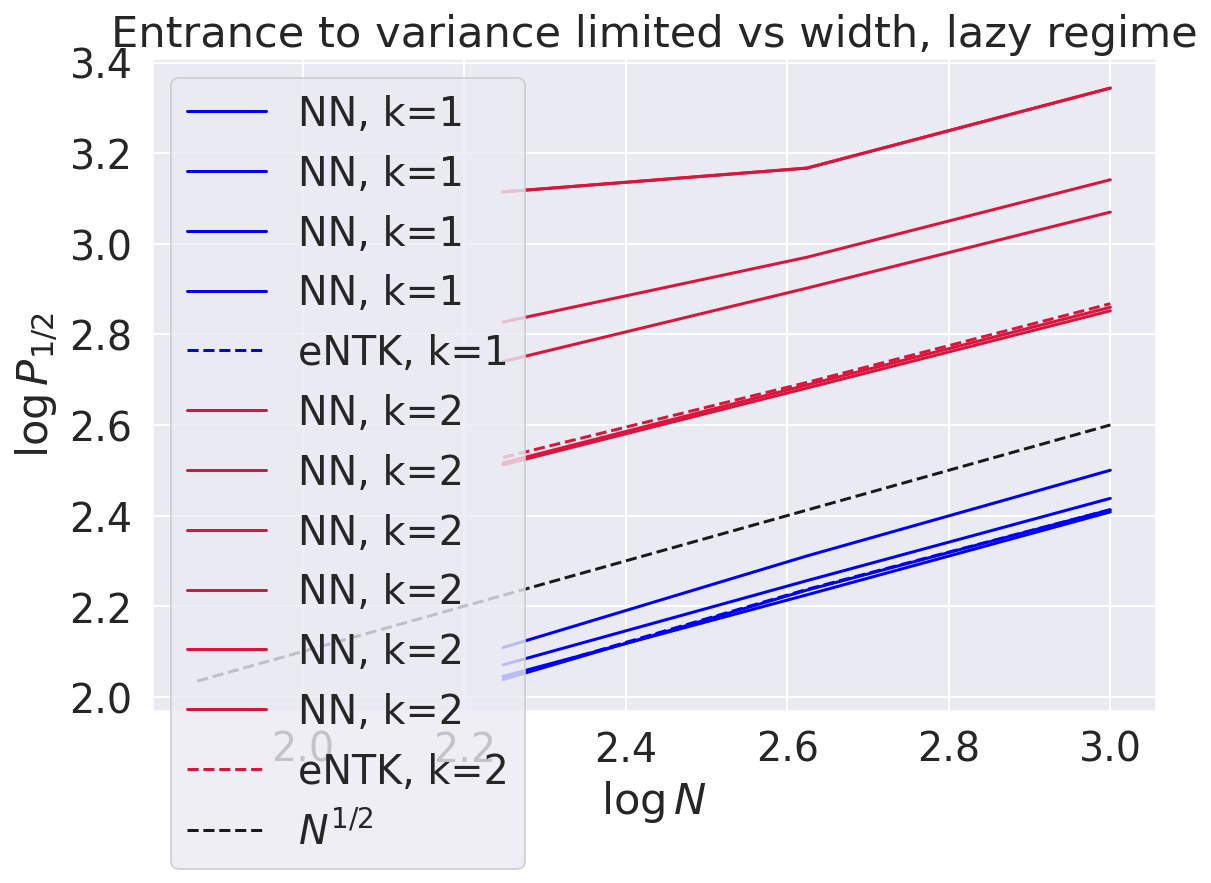

In [68]:
plt.figure(figsize=(9, 6))
# plt.plot(np.log10(widths[:]), halves[0, 0, :],c="blue", label="NN, k=1")
# plt.plot(np.log10(widths[:-1]), halveseNTK[0, :-1], '--', c="blue", label="eNTK, k=1")

plt.plot(np.log10(widths[1:]), halves[0, 0, 1:], c="blue", label="NN, k=1")
plt.plot(np.log10(widths[1:]), halves[0, 1, 1:], c="blue", label="NN, k=1")
plt.plot(np.log10(widths[1:]), halves[0, 2, 1:], c="blue", label="NN, k=1")
plt.plot(np.log10(widths[1:]), halves[0, 4, 1:], c="blue", label="NN, k=1")
plt.plot(np.log10(widths[1:]), halveseNTK[0, 1:], '--', c="blue", label="eNTK, k=1")


plt.plot(np.log10(widths[1:]), halves[1, 0, 1:], c="crimson", label="NN, k=2")
plt.plot(np.log10(widths[1:]), halves[1, 1, 1:], c="crimson", label="NN, k=2")
plt.plot(np.log10(widths[1:]), halves[1, 2, 1:], c="crimson", label="NN, k=2")
plt.plot(np.log10(widths[1:]), halves[1, 3, 1:], c="crimson", label="NN, k=2")
plt.plot(np.log10(widths[1:]), halves[1, 4, 1:], c="crimson", label="NN, k=2")
plt.plot(np.log10(widths[1:]), halves[1, 0, 1:], c="crimson", label="NN, k=2")
plt.plot(np.log10(widths[1:]), halveseNTK[1, 1:], '--', c="crimson", label="eNTK, k=2")



plt.plot(np.log10(widths[:]), 1.1 + 0.5 * np.log10(widths[:]), 'k--', label="$N^{{1/2}}$")
plt.xlabel("$\\log N$")
plt.ylabel("$\\log P_{1/2}$")
plt.title("Entrance to variance limited vs width, lazy regime")
plt.legend()


In [72]:
sigmas = np.array(sigmas)
sigmas

array([ 0.1,  0.5,  1. , 10. , 20. ])

<ipython-input-86-16c816490fc5>:8: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', color='w', linewidth=1.0)
<ipython-input-86-16c816490fc5>:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='minor', color='w', linewidth=0.5)


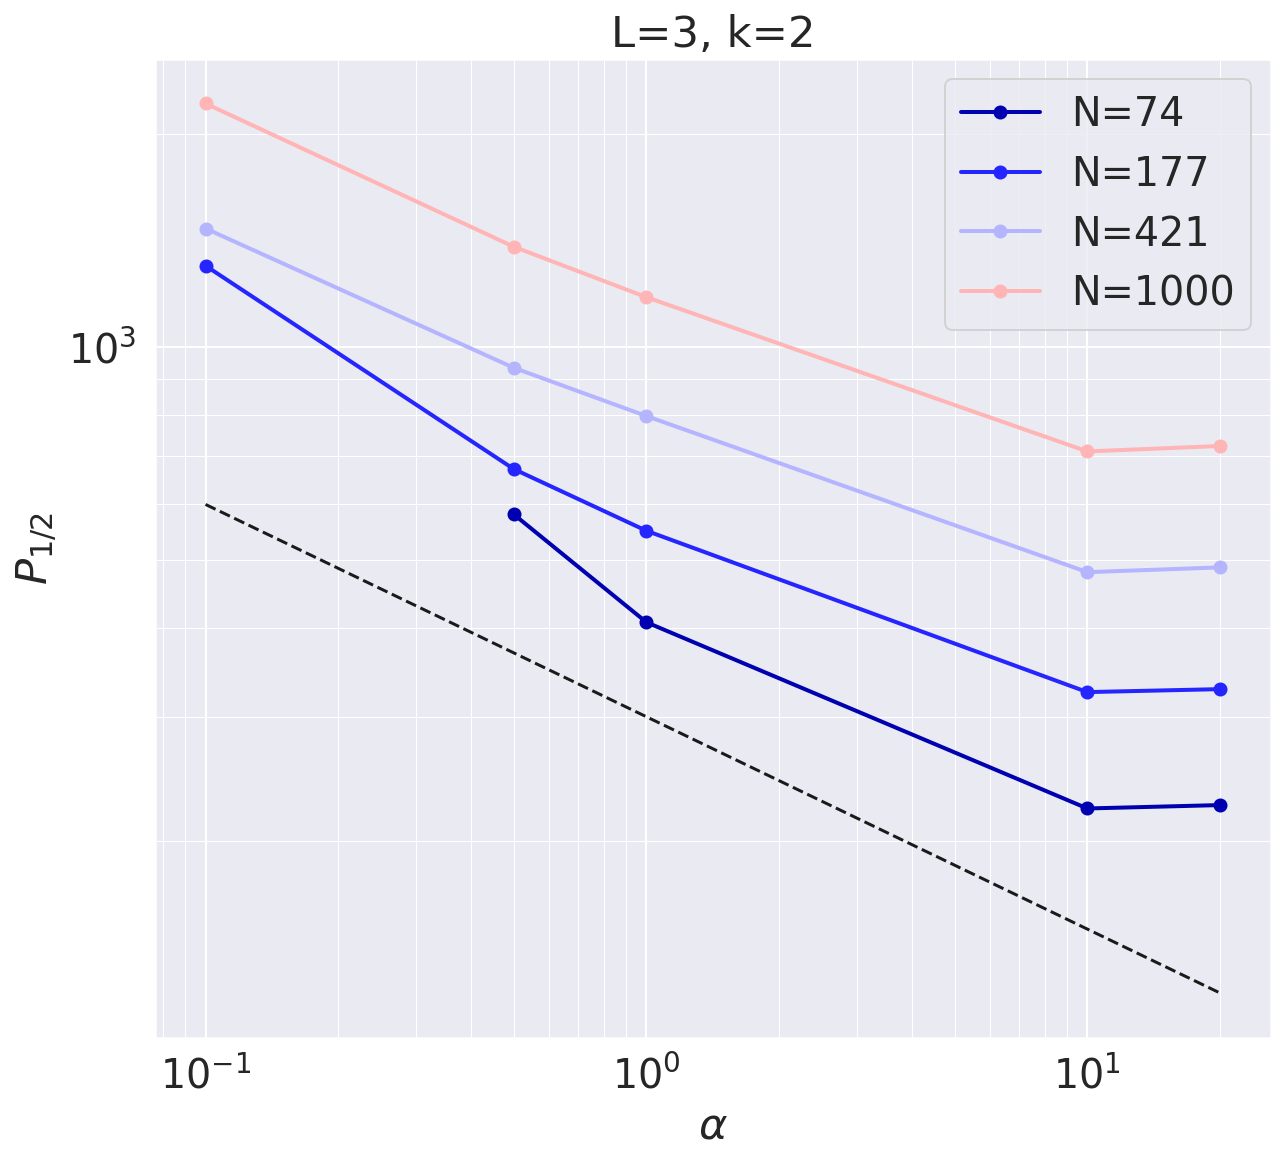

In [86]:
import matplotlib as mpl
fig = plt.figure(figsize=(10, 9))
ax = plt.axes()
k=2
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)
for i, width in enumerate(widths):
  if i == 0:
    ax.loglog(np.array(sigmas[1:]),  np.power(10, halves[1, 1:, i]), 'o-', label=f"N={width}", linewidth=2)
  else:
    ax.loglog(np.array(sigmas[:]),  np.power(10, halves[1, :, i]), 'o-', label=f"N={width}", linewidth=2)

# ax.tick_params(axis='both', which='minor', labelsize=14)
# ax.tick_params(axis='both', which='major')
# plt.yticks([1e2, 3e2, 4e2, 6e2, 1e3])
# plt.tight_layout()
# plt.xticks([1e-1, 5e-1, 1e0, 5e0, 1e1, 2e1])
plt.plot(sigmas, 3e2*sigmas**(-0.3), 'k--')

plt.title(f"L={depth}, k={k}")
plt.xlabel("$\\alpha$")
plt.ylabel("$P_{1/2}$")
plt.legend()
plt.savefig(f"figures/half_variance_L={depth}_k={k}.pdf",bbox_inches="tight")

<ipython-input-75-07b28d5392f9>:5: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', color='w', linewidth=1.0)
<ipython-input-75-07b28d5392f9>:6: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='minor', color='w', linewidth=0.5)


Text(0, 0.5, '$P_{{1/2}}$')

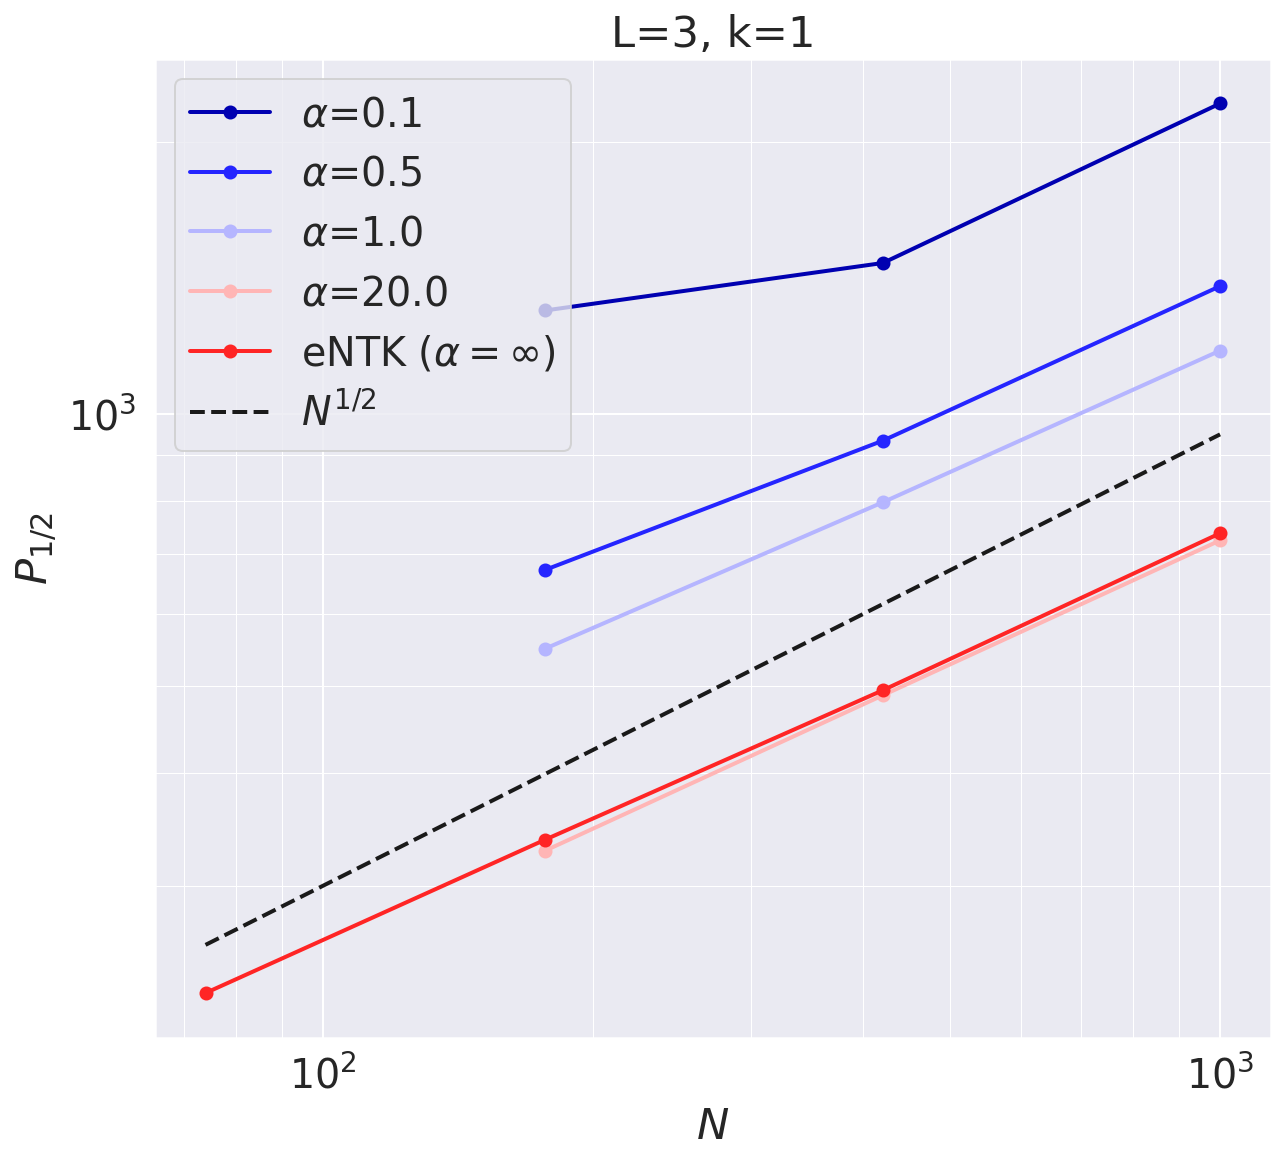

In [75]:
fig = plt.figure(figsize=(10, 9))
ax = plt.axes()
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)
for i, sigma in enumerate(sigmas):
  if i == 3: 
    continue 
    #ax.loglog(np.array(widths[1:]),  np.power(10, halves[1, i, 1:]) , 'o-',label=f"$\\alpha$={sigma}", linewidth=2)
  else:
    ax.loglog(np.array(widths[1:]),  np.power(10, halves[1, i, 1:]) , 'o-',label=f"$\\alpha$={sigma}", linewidth=2)
    # ax.loglog(np.array(widths),  np.power(10, halves[1, i, :]) , 'o-',label=f"$\\alpha$={sigma}", linewidth=2)
ax.loglog(np.array(widths),  np.power(10, halveseNTK[1, :]) ,'o-', label=f"eNTK ($\\alpha=\infty$)", linewidth=2)
ax.loglog(np.array(widths), 3e1*np.power(np.array(widths), 0.5), 'k--', label="$N^{{1/2}}$", linewidth=2)
  
plt.legend()

plt.title(f"L={depth}, k={k}")
plt.xlabel("$N$")
plt.ylabel("$P_{{1/2}}$")
# plt.savefig(f"figures/half_variance_N_scaling_L={depth}_k={k}.pdf",bbox_inches="tight")

In [ ]:
test_key = random.PRNGKey(0)
beta_key, const_key, test_key = random.split(test_key, 3)

# # Data:
# ks = [1,2,3,4]
# ys_test = []
k=2

beta = generate_synth_data(1, dim, beta_key)[0,:]
y_const = np.sqrt(np.mean((generate_train_data(1000, beta, k, const_key)[1])**2))
Xs_train = []; ys_train = []
for i, p in enumerate(pvals):
  X_train, y_train = generate_train_data(p, beta, k, train_key[i])
  y_train = y_train/y_const
  Xs_train += [X_train]
  ys_train += [y_train]
X_test, y_test = generate_train_data(p_test, beta, k, test_key)
y_test = y_test/y_const
# ys_test +=[y_test]
test_set = X_test, y_test

In [ ]:
from functools import partial
import numpy as np
from jax.tree_util import tree_map, tree_flatten

def l2_norm(tree):
  """Compute the l2 norm of a pytree of arrays. Useful for weight decay."""
  leaves, _ = tree_flatten(tree)
  return jnp.sqrt(sum(jnp.vdot(x, x) for x in leaves))

width = 1000

sigma = 20.0
numP = 15
numS = 5
align_tr = np.zeros((numS, numP, numD))
align_te = np.zeros((numS, numP, numD))

key1, key2 = random.split(random.PRNGKey(0))
num_samples = 100
P_test = 2000

X_test = test_set[0]
y_test = test_set[1]
e = 0

for i, sigma in enumerate(sigmas):
  init_fn, apply_fn, kernel_fn = fully_connected(layers, width, np.power(sigma, 1/depth))
  apply_fn = jit(apply_fn)
  align = lambda params, X, y:  jnp.dot(y.T,  apply_fn(params, X) )[-1, 0]
  grad_align = grad(align)
  NTK_align = jit( lambda params, X, y: l2_norm(grad_align(params, X, y)) )
  for d in range(numD):
    print(f"s = {sigma}, d = {d}")
    try:
      # params0s = jnp.load(savedir + "params0_N={}_L={}_k={}_s={:.2f}_d={}.npy".format(width, depth, k, sigma, d), allow_pickle=True)
      paramsfs = jnp.load(savedir + "paramsf_N={}_L={}_k={}_s={:.2f}_d={}.npy".format(width, depth, k, sigma, d), allow_pickle=True)
    except:
      print(f"Error at N={width}, s={sigma}, d = {d}")
      continue

    
    for pidx in range(numP):
      u_tr = jax.random.normal(key1, shape=(pvals[pidx], 1, num_samples))/np.sqrt(num_samples * pvals[pidx])
      u_te = jax.random.normal(key2, shape=(P_test, 1, num_samples))/np.sqrt(num_samples * P_test)
      # params0 = make_jax(params0s[pidx][e])
      paramsf = make_jax(paramsfs[pidx][e])
      X = train_sets[d][0][pidx]
      y = train_sets[d][1][pidx]
      trK = jnp.sum(vmap(lambda y: NTK_align(paramsf, X, y), in_axes=-1)(u_tr))
      align_tr[i, pidx, d] = jax.device_get ( NTK_align(paramsf, X, y)/(np.dot(y.T, y)[0, 0] * trK) ) 
      X = X_test
      y = y_test
      trK = jnp.sum(vmap(lambda y: NTK_align(params0, X, y), in_axes=-1)(u_te))
      align_te[i, pidx, d] = jax.device_get (  NTK_align(paramsf, X, y)/(np.dot(y.T, y)[0, 0] * trK) ) 




/n/home00/aatanasov/.conda/envs/ffcv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig.canvas.print_figure(bytes_io, **kw)


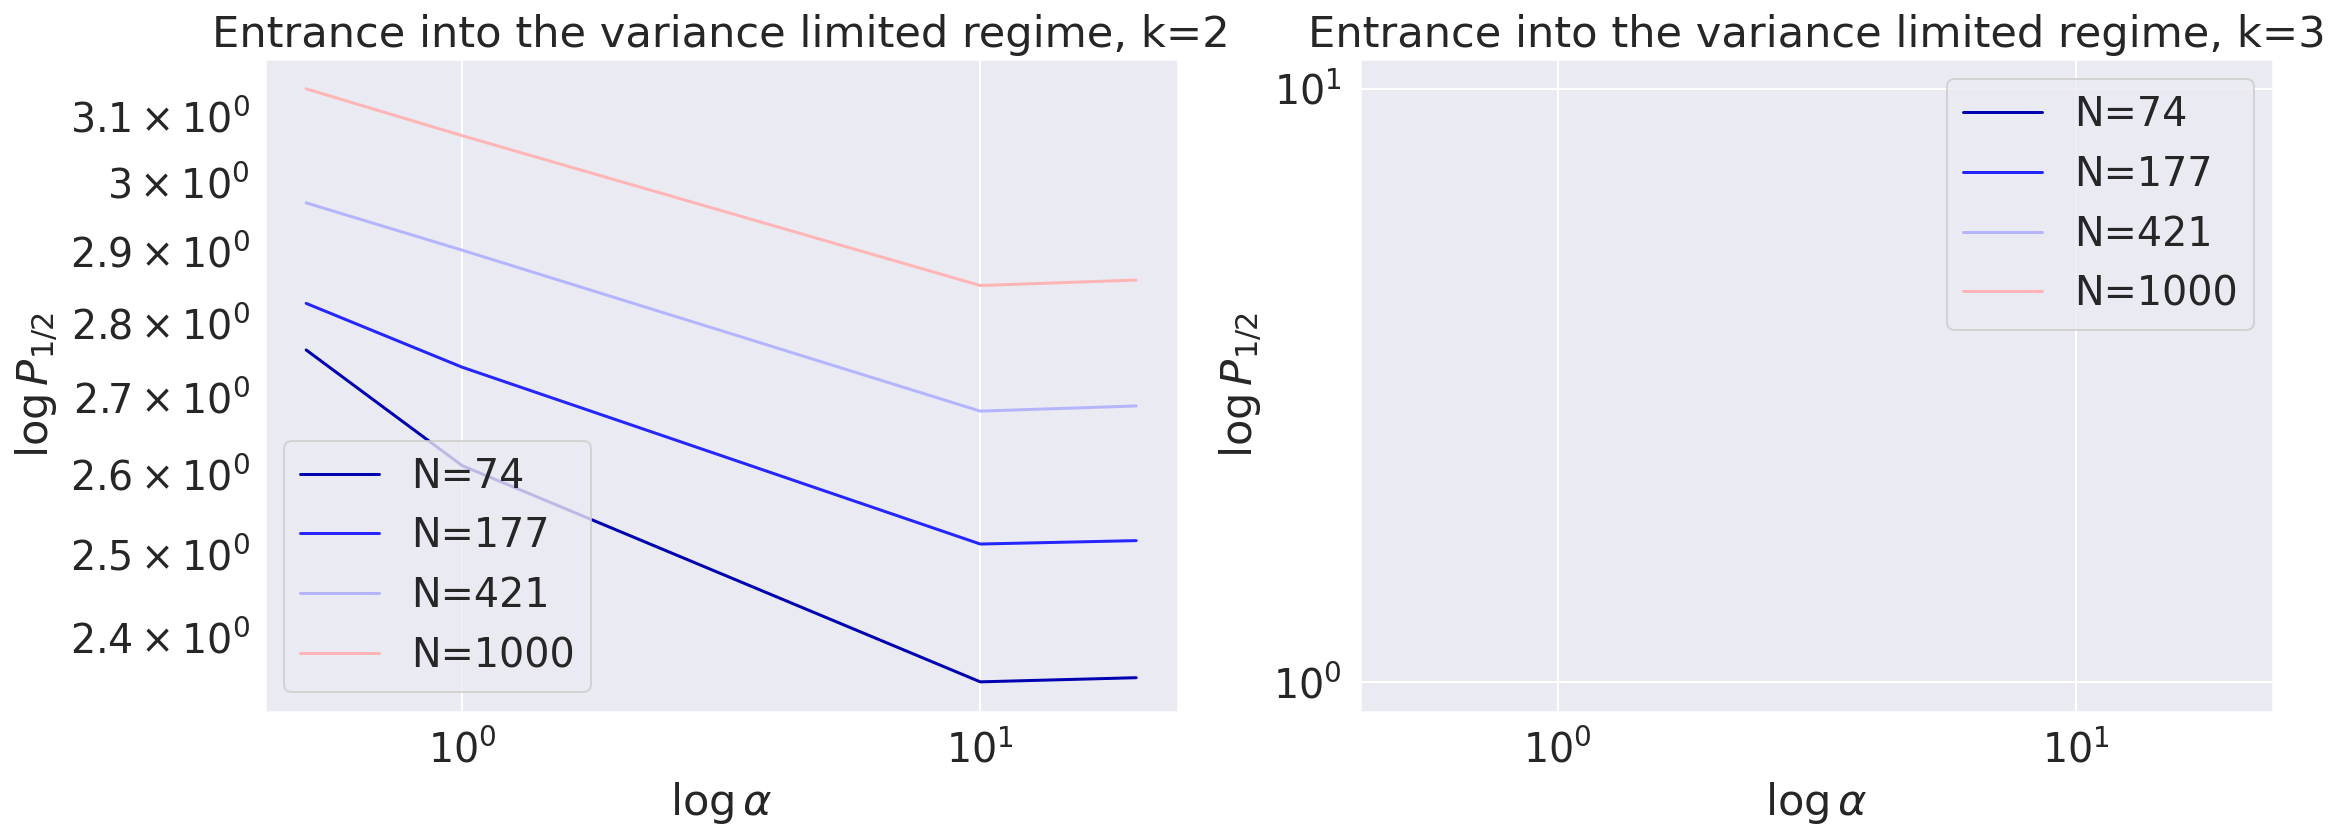

In [115]:
plt.figure(figsize=(18, 6))
for idk, k in enumerate([1,2,3]):
  if idk < 1: continue
  plt.subplot(1,2,idk)
  plt.title(f"Entrance into the variance limited regime, k={k}")
  for i, width in enumerate(widths):
      if i == 0:
          plt.loglog(np.array(sigmas[1:]),  halves[idk, 1:, i] , label=f"N={width}")
      else:
          plt.loglog(np.array(sigmas[1:]), halves[idk, 1:, i] , label=f"N={width}")
  plt.xlabel("$\\log \\alpha$")
  plt.ylabel("$\\log P_{1/2}$")
  plt.legend()
#     plt.loglog(np.array(sigmas) * np.sqrt(width), 1e3* np.power(np.array(sigmas) * np.sqrt(width), -1), 'k--')


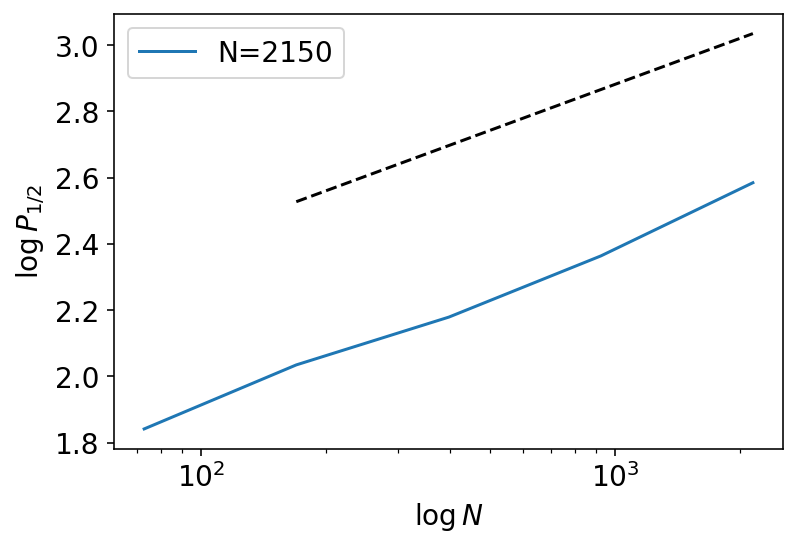

In [134]:

plt.semilogx(widths, halves[-1, :], label=f"N={width}")
plt.plot(widths[1:], 1.5 + 0.2 * np.log(widths[1:]), 'k--')
plt.xlabel("$\\log N$")
plt.ylabel("$\\log P_{1/2}$")
plt.legend()

2.754402942564411

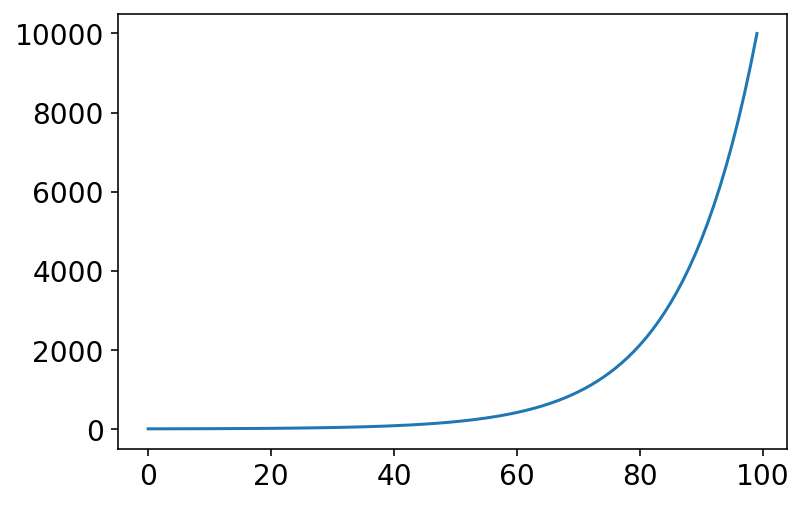

In [40]:
plt.plot(xnew)

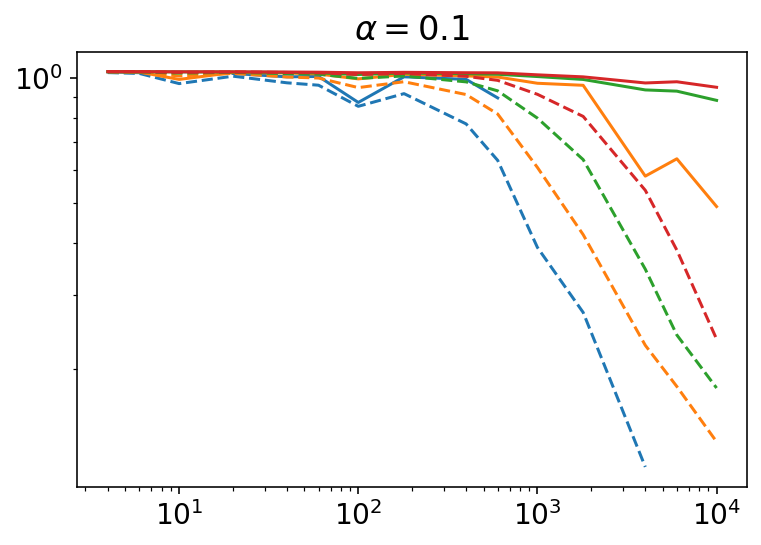

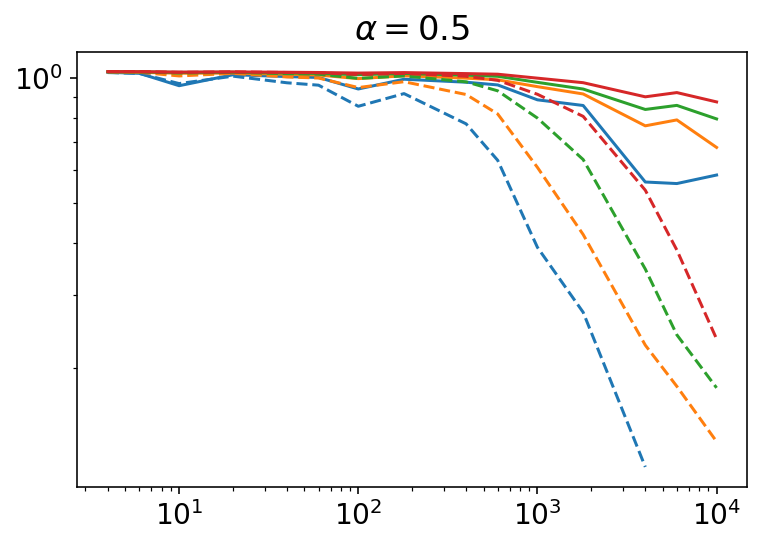

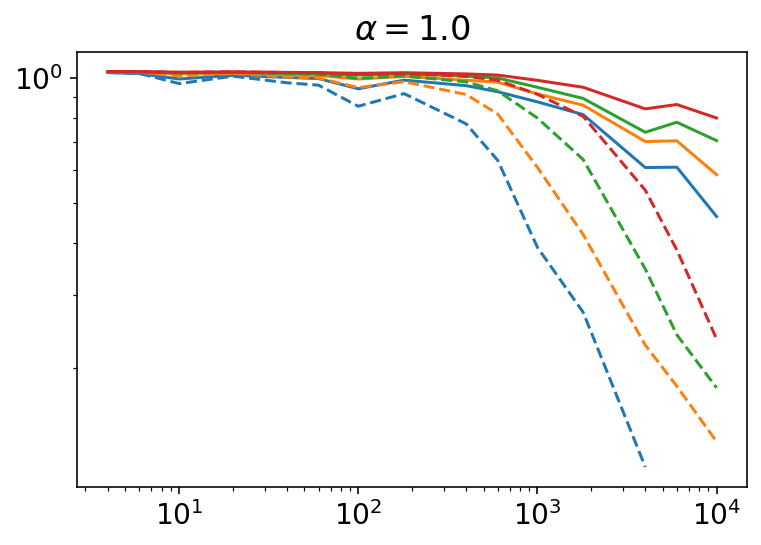

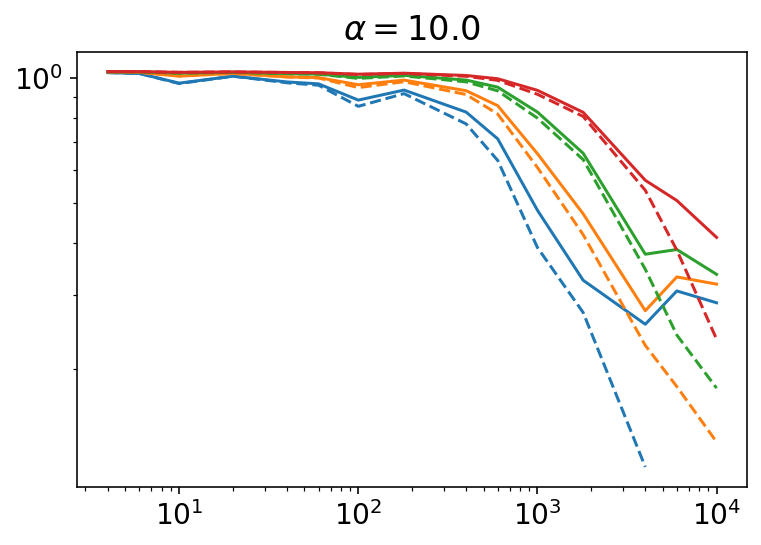

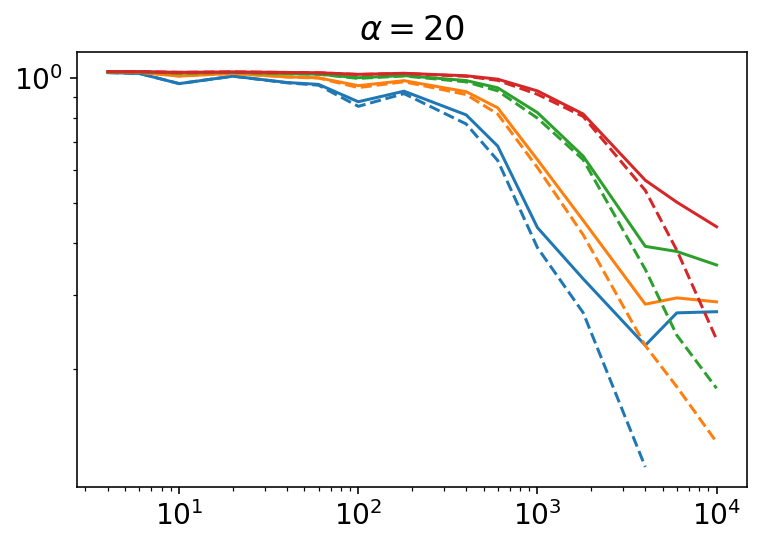

In [15]:
for i, sigma in enumerate(sigmas):
    plt.figure()
    plt.title(f"$\\alpha={sigma}$")
    for j in range(len(widths)):
        plt.loglog(pvals, NN_err_rat[i, j, :], f'C{j}')
        plt.loglog(pvals, eNTK0_err_rat[i, j, :], f'C{j}--')



In [241]:
k = 4
width = nvals[-4]
sigma = 20
all_eNTK0s_lazy = jnp.load(savedir + "all_eNTK0s_N={}_L={}_k={}_s={:.2f}.npy".format(width, depth, k, sigma), allow_pickle=True)
all_eNTKfs_lazy = jnp.load(savedir + "all_eNTKfs_N={}_L={}_k={}_s={:.2f}.npy".format(width, depth, k, sigma), allow_pickle=True)
all_eNTK0s_inv_lazy = jnp.load(savedir + "all_eNTK0s_inv_N={}_L={}_k={}_s={:.2f}.npy".format(width, depth, k, sigma), allow_pickle=True)
all_eNTKfs_inv_lazy = jnp.load(savedir + "all_eNTKfs_inv_N={}_L={}_k={}_s={:.2f}.npy".format(width, depth, k, sigma), allow_pickle=True)


sigma = 0.1
all_eNTK0s_rich = jnp.load(savedir + "all_eNTK0s_N={}_L={}_k={}_s={:.2f}.npy".format(width, depth, k, sigma), allow_pickle=True)
all_eNTKfs_rich = jnp.load(savedir + "all_eNTKfs_N={}_L={}_k={}_s={:.2f}.npy".format(width, depth, k, sigma), allow_pickle=True)
all_eNTK0s_inv_rich = jnp.load(savedir + "all_eNTK0s_inv_N={}_L={}_k={}_s={:.2f}.npy".format(width, depth, k, sigma), allow_pickle=True)
all_eNTKfs_inv_rich = jnp.load(savedir + "all_eNTKfs_inv_N={}_L={}_k={}_s={:.2f}.npy".format(width, depth, k, sigma), allow_pickle=True)

avg_eNTK0s_lazy = [jnp.mean(jnp.array([all_eNTK0s_lazy[i][j] for j in range(10)]), axis=0) for i in range(len(pvals[7:-1]))]
avg_eNTKfs_lazy = [jnp.mean(jnp.array([all_eNTKfs_lazy[i][j] for j in range(10)]), axis=0) for i in range(len(pvals[7:-1]))]
avg_eNTK0s_rich = [jnp.mean(jnp.array([all_eNTK0s_rich[i][j] for j in range(10)]), axis=0) for i in range(len(pvals[7:-1]))]
avg_eNTKfs_rich = [jnp.mean(jnp.array([all_eNTKfs_rich[i][j] for j in range(10)]), axis=0) for i in range(len(pvals[7:-1]))]

avg_eNTK0s_inv_lazy = [jnp.mean(jnp.array([all_eNTK0s_inv_lazy[i][j] for j in range(10)]), axis=0) for i in range(len(pvals[7:-1]))]
avg_eNTKfs_inv_lazy = [jnp.mean(jnp.array([all_eNTKfs_inv_lazy[i][j] for j in range(10)]), axis=0) for i in range(len(pvals[7:-1]))]
avg_eNTK0s_inv_rich = [jnp.mean(jnp.array([all_eNTK0s_inv_rich[i][j] for j in range(10)]), axis=0) for i in range(len(pvals[7:-1]))]
avg_eNTKfs_inv_rich = [jnp.mean(jnp.array([all_eNTKfs_inv_rich[i][j] for j in range(10)]), axis=0) for i in range(len(pvals[7:-1]))]

FileNotFoundError: [Errno 2] No such file or directory: '/n/holyscratch01/pehlevan_lab/Lab/aatanasov/all_eNTK0s_N=397_L=3_k=4_s=20.00.npy'

In [230]:
Ps = np.array(pvals[7:-1])
std0_lazy = [1/10 * 1/p**2 * np.sum([np.sum((eNTK0 - avg)**2) for eNTK0 in eNTK0s]) for eNTK0s, p, avg in zip(all_eNTK0s_lazy, Ps, avg_eNTK0s_lazy)]
stdf_lazy = [1/10 * 1/p**2 * np.sum([np.sum((eNTKf - avg)**2) for eNTKf in eNTKfs]) for eNTKfs, p, avg in zip(all_eNTKfs_lazy, Ps, avg_eNTKfs_lazy)]
std0_rich = [1/10 * 1/p**2 * np.sum([np.sum((eNTK0 - avg)**2) for eNTK0 in eNTK0s]) for eNTK0s, p, avg in zip(all_eNTK0s_rich, Ps, avg_eNTK0s_rich)]
stdf_rich = [1/10 * 1/p**2 * np.sum([np.sum((eNTKf - avg)**2) for eNTKf in eNTKfs]) for eNTKfs, p, avg in zip(all_eNTKfs_rich, Ps, avg_eNTKfs_rich)]

In [231]:
std0_inv_lazy = [1/10 * 1/p**2 * np.sum([np.sum((eNTK0 - avg)**2) for eNTK0 in eNTK0s]) for eNTK0s, p, avg in zip(all_eNTK0s_inv_lazy, Ps, avg_eNTK0s_inv_lazy)]
stdf_inv_lazy = [1/10 * 1/p**2 * np.sum([np.sum((eNTKf - avg)**2) for eNTKf in eNTKfs]) for eNTKfs, p, avg in zip(all_eNTKfs_inv_lazy, Ps, avg_eNTKfs_inv_lazy)]
std0_inv_rich = [1/10 * 1/p**2 * np.sum([np.sum((eNTK0 - avg)**2) for eNTK0 in eNTK0s]) for eNTK0s, p, avg in zip(all_eNTK0s_inv_rich, Ps, avg_eNTK0s_inv_rich)]
stdf_inv_rich = [1/10 * 1/p**2 * np.sum([np.sum((eNTKf - avg)**2) for eNTKf in eNTKfs]) for eNTKfs, p, avg in zip(all_eNTKfs_inv_rich, Ps, avg_eNTKfs_inv_rich)]

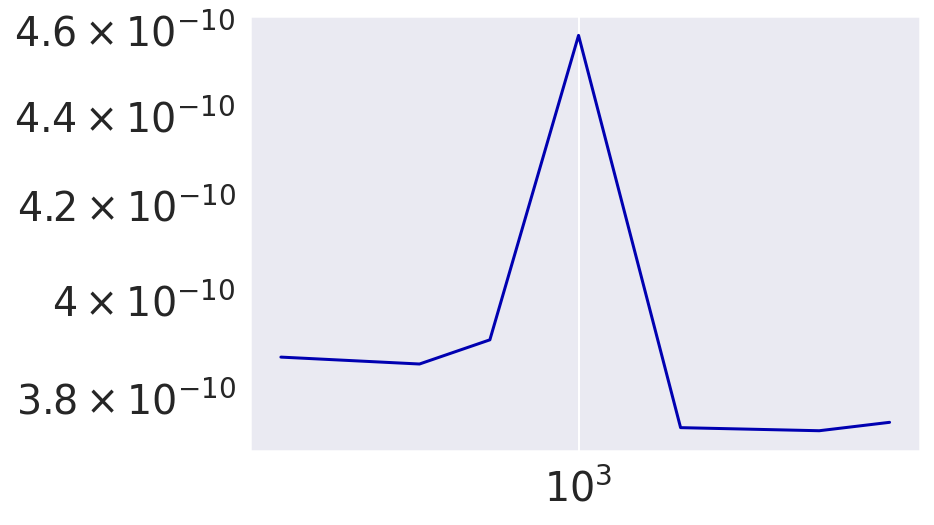

In [236]:
plt.loglog(Ps, std0_rich)

In [31]:
cond0_lazy = [[np.linalg.cond(eNTK) for eNTK in eNTKs] for eNTKs in all_eNTK0s_lazy]
condf_lazy = [[np.linalg.cond(eNTK) for eNTK in eNTKs] for eNTKs in all_eNTKfs_lazy]
cond0_rich = [[np.linalg.cond(eNTK) for eNTK in eNTKs] for eNTKs in all_eNTK0s_rich]
condf_lazy = [[np.linalg.cond(eNTK) for eNTK in eNTKs] for eNTKs in all_eNTKfs_rich]

KeyboardInterrupt: 

In [87]:
width = 10
init_fn, apply_fn, kernel_fn = fully_connected(layers, width, np.power(sigma, 1/depth))
apply_fn = jit(apply_fn)
kernel_fn = jit(kernel_fn, static_argnums=(2,))


In [114]:
p_te = 20000
X_te, _ = generate_train_data(p_te, beta, k, test_key)

In [115]:
K = kernel_fn(X_te, X_te)

In [116]:
evals = jnp.linalg.eigvalsh(K.ntk)

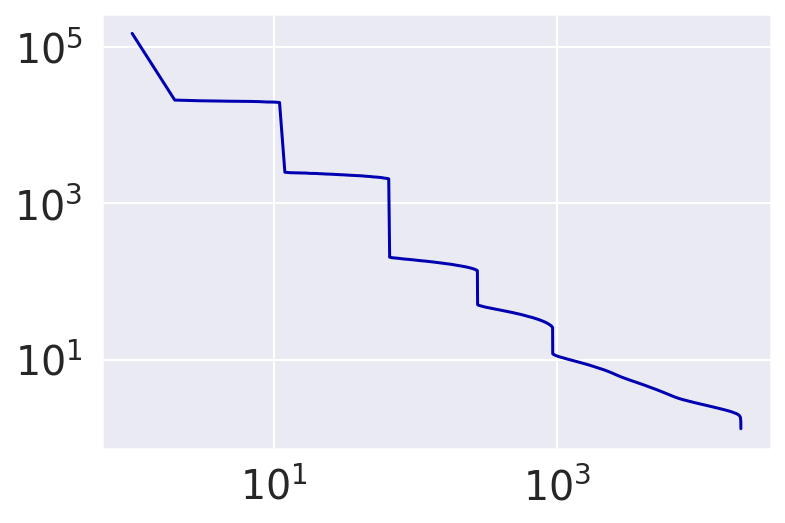

In [117]:
plt.loglog(np.arange(1, len(evals)+1), sorted(evals)[::-1])

In [118]:
jnp.save("pn_sweeps/evals_inf", evals.sort()[::-1])